# Imports + Config

In [2]:
# ==============================================================================
# 🎯 CELL 1: XAI SETUP (CLEANED OF LLM AGENT CODE) 🎯
# ==============================================================================

# --------------------------
# 1. INSTALL AND UPGRADE LIBS (REMOVED: LLM-RELATED LIBRARIES)
# --------------------------
# (If needed, other libraries would be installed here. Assuming core libraries are present.)
print("1. Installing and upgrading necessary libraries... (LLM component removed)")

# --------------------------
# 2. CORE IMPORTS (ONLY RETAINING ML/UTILITY LIBRARIES)
# Insert this line with your other imports
# Necessary imports for data and models
# --------------------------
# 2. CORE IMPORTS
# --------------------------
import os
import random
import pandas as pd # <-- FIX for NameError: name 'pd' is not defined
import json
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, random_split, DataLoader # <-- All necessary data utilities
from torchvision import transforms, datasets, models # <-- All necessary torchvision components
import matplotlib.pyplot as plt
from PIL import Image
from typing import List, Dict, Any, Callable
# ... rest of your code
# --------------------------
import os
import random
import json
import numpy as np
import cv2
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image
from typing import List, Dict, Any, Callable

# --------------------------
# 3. GLOBAL SETUP & PLACEHOLDERS
# --------------------------
print("2. Setting up global variables...")

# --- LLM SETUP (REMOVED) ---

# --- DEVICE SETUP ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- DATA PLACEHOLDERS ---
# NOTE: Your actual 'class_names' and 'external_dataset' must be defined 
# in the next cell where you load your data.
try:
    if 'class_names' not in globals():
        class_names = ['Normal', 'Ischemic', 'Bleeding'] # Default labels
    if 'external_dataset' not in globals():
        # This is a placeholder. You MUST load your dataset in the next cell!
        print("⚠️ Warning: 'external_dataset' not yet loaded. Ensure it's defined later.")
except NameError:
    # Handles initial runs where the variable hasn't even been assigned.
    class_names = ['Normal', 'Ischemic', 'Bleeding'] 

# ----------------------------------------------------
# 4. XAI HELPER FUNCTIONS
# ----------------------------------------------------

def get_target_layer(model, model_name):
    """Selects the last convolutional layer for Grad-CAM."""
    if model_name == "CNN":
        # Adjust based on your model's exact layer structure
        return model.layer2[0] 
    if model_name == "ResNet18":
        return model.layer4[-1].conv2
    if model_name == "AlexNet":
        for layer in reversed(model.features):
            if isinstance(layer, nn.Conv2d):
                return layer
        raise ValueError(f"No target conv layer defined for model {model_name}")

def generate_gradcam(model, img_tensor, target_layer):
    """Generates the raw Grad-CAM heatmap (numpy array)."""
    model.eval()
    hook_data = {'activations': [], 'gradients': []}

    def forward_hook(module, input, output):
        hook_data['activations'].append(output)
    def backward_hook(module, grad_input, grad_output):
        hook_data['gradients'].append(grad_output[0])

    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()

    model.zero_grad()
    class_score = output[0, pred_class]
    class_score.backward()
    
    forward_handle.remove()
    backward_handle.remove()

    act = hook_data['activations'][0][0]
    grads = hook_data['gradients'][0][0]
    weights = grads.mean(dim=(1, 2))

    cam = torch.zeros(act.shape[1:], dtype=torch.float32)
    for i, w in enumerate(weights):
        cam += w * act[i]
        
    cam = cam.detach().cpu().numpy()
    cam = np.maximum(cam, 0)
    # Handle division by zero
    max_val = cam.max()
    if max_val > 0:
        cam /= max_val
    else:
        cam = np.zeros_like(cam) # If max is 0, heatmap is all black

    return cam, pred_class

def overlay_cam_on_image(img_path, cam, output_dir, model_name, true_label):
    """Overlays CAM on the original image and saves it."""
    orig = np.array(Image.open(img_path).convert("RGB"))
    
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
    
    overlay = np.uint8(0.5 * heatmap + 0.5 * orig)
    
    save_path = os.path.join(output_dir, f"{model_name}_{true_label}_XAI_Output.png")
    plt.imsave(save_path, overlay)
    
    return save_path

# ----------------------------------------------------
# 5. THE CORE DIAGNOSTIC TOOL
# ----------------------------------------------------

def run_diagnostic_tool(case_idx):
    """
    Runs all models, XAI, and prepares the data for analysis. 
    Requires cnn, resnet, alexnet, and external_dataset to be defined globally.
    """
    # Safety Check: assumes models are defined (e.g., in Cell 2)
    if 'cnn' not in globals() or 'resnet' not in globals():
        raise NameError("Models (cnn, resnet, alexnet) not found. Please define them in the next cell.")

    img, label = external_dataset[case_idx]
    # This assumes your dataset returns path as the first element of its items list.
    img_path = external_dataset.items[case_idx][0] 
    img_tensor = img.unsqueeze(0).to(device)
    true_label = class_names[label]
    
    output_dir = "agent_xai_outputs"
    os.makedirs(output_dir, exist_ok=True)
    
    models_dict = {
        "CNN": (cnn, "CNN"),
        "ResNet18": (resnet, "ResNet18"),
        "AlexNet": (alexnet, "AlexNet")
    }
    
    results = []
    for model_name, (model, target_name) in models_dict.items():
        target_layer = get_target_layer(model, model_name)
        cam, pred_idx = generate_gradcam(model, img_tensor, target_layer)
        pred_label = class_names[pred_idx]
        
        overlay_path = overlay_cam_on_image(
            img_path, cam, output_dir, model_name, true_label
        )
        
        results.append({
            'model': model_name,
            'prediction': pred_label,
            'xai_path': overlay_path,
            'true_label': true_label
        })
        
    return results

# ----------------------------------------------------
# 6. LLM-CALLABLE TOOL WRAPPER (REMOVED)
# ----------------------------------------------------

print("3. All foundational functions defined.")
print("\n🔥 READY TO PROCEED! Define your data and models in the next cell.")

1. Installing and upgrading necessary libraries... (LLM component removed)
2. Setting up global variables...
⚠️ Warning: 'external_dataset' not yet loaded. Ensure it's defined later.
3. All foundational functions defined.

🔥 READY TO PROCEED! Define your data and models in the next cell.


# Paths + Transformations

In [5]:
data_dir = r"C:\Users\Sajid\Downloads\archive (1)\Brain_Stroke_CT_Dataset"

# Convert grayscale → RGB for pretrained networks
class GrayToRGB:
    def __call__(self, img):
        if img.mode != 'RGB':
            return img.convert('RGB')
        return img

train_transform = transforms.Compose([
    GrayToRGB(),
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    GrayToRGB(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])


# Load Dataset (PNG only)

In [6]:
# Flatten your dataset structure if needed: use only "png" subfolders
def flatten_png_folders(base_dir):
    classes = ["Normal", "Ischemia", "Bleeding"]
    temp_root = os.path.join(base_dir, "trainval_temp")
    os.makedirs(temp_root, exist_ok=True)
    for cls in classes:
        src = os.path.join(base_dir, cls, "png")
        dst = os.path.join(temp_root, cls)
        os.makedirs(dst, exist_ok=True)
        for f in os.listdir(src):
            if f.lower().endswith(".png"):
                src_f = os.path.join(src, f)
                dst_f = os.path.join(dst, f)
                if not os.path.exists(dst_f):
                    try:
                        os.symlink(os.path.abspath(src_f), dst_f)
                    except:
                        from shutil import copy2
                        copy2(src_f, dst_f)
    return temp_root

dataset_root = flatten_png_folders(data_dir)


# ImageFolder + Train/Val Split

In [7]:
import torch # Import if not already done
import random # Import if not already done
# Assuming dataset_root, train_transform, and val_transform are defined above.

# 1. Create two base datasets (one for train, one for val)
#    This ensures they have independent 'transform' attributes.
full_dataset_train = datasets.ImageFolder(root=dataset_root, transform=train_transform)
full_dataset_val = datasets.ImageFolder(root=dataset_root, transform=val_transform) 

class_names = full_dataset_train.classes
print("Classes:", class_names, "Total images:", len(full_dataset_train))

# 2. Split the dataset indices (not the datasets themselves)
train_size = int(0.8 * len(full_dataset_train))
val_size = len(full_dataset_train) - train_size

# Use random_split on the training dataset to get the split indices (Subset objects)
train_subset_indices, val_subset_indices = random_split(full_dataset_train, [train_size, val_size])

# 3. Create the final datasets (Subset objects)
#    - train_dataset points to the augmented (train) base dataset.
#    - val_dataset points to the non-augmented (val) base dataset, but uses the same indices.
train_dataset = train_subset_indices
val_dataset = torch.utils.data.Subset(full_dataset_val, val_subset_indices.indices)

# 4. Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)}")

Classes: ['Bleeding', 'Ischemia', 'Normal'] Total images: 6650
Train: 5320 | Val: 1330


# Models

In [8]:
class CNNModel(nn.Module):
    def __init__(self, num_classes=3):
        super(CNNModel, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # ✅ 3 → 32
            nn.BatchNorm2d(32),                           # ✅ BN(32)
            nn.ReLU(),
            nn.MaxPool2d(2)                               # 512 → 256
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # ✅ 32 → 64
            nn.BatchNorm2d(64),                           # ✅ BN(64)
            nn.ReLU(),
            nn.MaxPool2d(2)                               # 256 → 128
        )

        self.gap = nn.AdaptiveAvgPool2d((1,1))           # ✅ output = (64,1,1)

        self.fc = nn.Sequential(
            nn.Linear(64, 128),                           # ✅ matches weight shape
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.layer1(x)      # → (32, 256, 256)
        x = self.layer2(x)      # → (64, 128, 128)
        x = self.gap(x)         # → (64, 1, 1)
        x = torch.flatten(x, 1) # → (64)
        x = self.fc(x)
        return x


In [9]:
import os

folder = r"C:\Users\Sajid\Downloads\pro"
files = os.listdir(folder)

[p for p in files if p.endswith(".pth")]


['alexnet_model.pth', 'cnn_model.pth', 'resnet18_model.pth']

In [10]:
# ============================================
# ✅ Load ALL trained models (CNN, ResNet, AlexNet)
# ============================================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------------------
# ✅ Load Custom CNN
# ------------------------------
cnn = CNNModel(num_classes=3)
cnn_path = r"C:\Users\Sajid\Downloads\pro\cnn_model.pth"
cnn.load_state_dict(torch.load(cnn_path, map_location=device))
cnn.to(device)
cnn.eval()
print("✅ CNN loaded successfully")

# ------------------------------
# ✅ Load ResNet18
# ------------------------------
resnet = models.resnet18(weights=None)
resnet.fc = nn.Linear(resnet.fc.in_features, 3)

resnet_path = r"C:\Users\Sajid\Downloads\pro\resnet18_model.pth"   # ✅ FIXED PATH
resnet.load_state_dict(torch.load(resnet_path, map_location=device))
resnet.to(device)
resnet.eval()
print("✅ ResNet18 loaded successfully")

# ------------------------------
# ✅ Load AlexNet
# ------------------------------
alexnet = models.alexnet(weights=None)
alexnet.classifier[6] = nn.Linear(4096, 3)

alexnet_path = r"C:\Users\Sajid\Downloads\pro\alexnet_model.pth"
alexnet.load_state_dict(torch.load(alexnet_path, map_location=device))
alexnet.to(device)
alexnet.eval()
print("✅ AlexNet loaded successfully")

print("\n✅ ALL MODELS ARE READY FOR INFERENCE ✅")


Using device: cpu
✅ CNN loaded successfully
✅ ResNet18 loaded successfully
✅ AlexNet loaded successfully

✅ ALL MODELS ARE READY FOR INFERENCE ✅


# Training Loop

# External Test Dataset Class

In [11]:
from PIL import Image as PILImage

class ExternalTestDataset(Dataset):
    def __init__(self, images_dir, label_file, transform=None, class_names=None):
        self.images_dir = images_dir
        self.transform = transform
        self.class_names = class_names

        if label_file.endswith(".csv"):
            df = pd.read_csv(label_file)
        else:
            df = pd.read_excel(label_file)

        fname_col = 'image_id'
        label_col = 'Stroke'

        self.items = []
        for _, row in df.iterrows():
            img_name = str(row[fname_col]) + ".png"
            img_path = os.path.join(images_dir, img_name)
            if os.path.exists(img_path):
                self.items.append((img_path, int(row[label_col])))

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        img_path, label = self.items[idx]
        image = PILImage.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


# Load External Test DataLoader

In [12]:
external_dataset = ExternalTestDataset(
    images_dir=os.path.join(data_dir, "External_Test", "png"),
    label_file=os.path.join(data_dir, "External_Test", "labels.csv"),
    transform=val_transform,
    class_names=class_names
)

external_loader = DataLoader(external_dataset, batch_size=32, shuffle=False)
print("External test size:", len(external_dataset))


External test size: 200


# Evaluate Models on External Test Set

In [49]:
# ============================================================
#   COMBINED CONFUSION MATRIX HEATMAPS FOR ALL 3 MODELS
# ============================================================

import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np


def get_predictions(model, dataloader, device="cuda"):
    """
    Returns true labels and predicted labels for a model.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


def plot_combined_confusion(models, model_names, dataloader, class_names, device="cuda"):
    """
    Plots 3 confusion matrix heatmaps side by side:
    CNN | ResNet18 | AlexNet
    """

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))

    for i, (model, name) in enumerate(zip(models, model_names)):
        
        # Get predictions
        y_true, y_pred = get_predictions(model, dataloader, device)

        # Compute confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        cm_n = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

        # Plot
        sns.heatmap(
            cm_n,
            annot=True,
            fmt=".2f",
            cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names,
            ax=axs[i]
        )

        axs[i].set_title(f"{name} Confusion Matrix")
        axs[i].set_xlabel("Predicted")
        axs[i].set_ylabel("True")

    plt.tight_layout()
    plt.show()


# ============================================================
# EXAMPLE USAGE
# ============================================================

models = [cnn, resnet, alexnet]
model_names = ["CNN", "ResNet18", "AlexNet"]

class_names = ["Ischemic", "Hemorrhagic"]  # modify if needed

plot_combined_confusion(models, model_names, val_loader, class_names)


KeyboardInterrupt: 

# Grad Cam Helper

In [13]:
# Cell 0: Grad-CAM helper function
import cv2
import matplotlib.pyplot as plt
import torch.nn.functional as F

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_handles = []
        self._register_hooks()
        
    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()
        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0].detach()
        
        for name, module in self.model.named_modules():
            if name == self.target_layer:
                self.hook_handles.append(module.register_forward_hook(forward_hook))
                self.hook_handles.append(module.register_backward_hook(backward_hook))
                
    def __call__(self, x, class_idx=None):
        self.model.zero_grad()
        out = self.model(x)
        if class_idx is None:
            class_idx = out.argmax(dim=1).item()
        loss = out[0, class_idx]
        loss.backward()
        
        # Compute weights
        pooled_grads = torch.mean(self.gradients, dim=[0,2,3])
        activations = self.activations[0]
        for i in range(activations.shape[0]):
            activations[i, :, :] *= pooled_grads[i]
        heatmap = torch.sum(activations, dim=0)
        heatmap = F.relu(heatmap)
        heatmap /= torch.max(heatmap)
        heatmap = heatmap.cpu().numpy()
        return heatmap
    
    def remove_hooks(self):
        for h in self.hook_handles:
            h.remove()

def show_cam_on_image(img_tensor, heatmap):
    img = img_tensor.squeeze().permute(1,2,0).cpu().numpy()
    img = (img - img.min())/(img.max()-img.min())
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255*heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap*0.4 + np.uint8(img*255)
    plt.figure(figsize=(5,5))
    plt.imshow(superimposed_img.astype(np.uint8))
    plt.axis('off')
    plt.show()


# # Grad-CAM for CNN

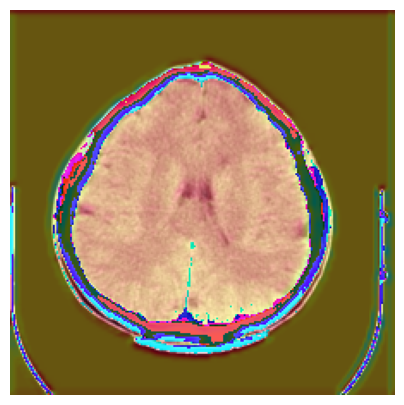

True label: Bleeding


In [14]:
# Cell 1: CNN Grad-CAM
cnn.eval()
# Target last conv layer
target_layer = 'layer2.0'  # first conv in layer2

gradcam = GradCAM(cnn, target_layer)

# Pick an image from external test set
img, label = external_dataset[0]
img_tensor = img.unsqueeze(0).to(device)

heatmap = gradcam(img_tensor)
show_cam_on_image(img, heatmap)

gradcam.remove_hooks()
print(f"True label: {class_names[label]}")


# Grad-CAM for ResNet18

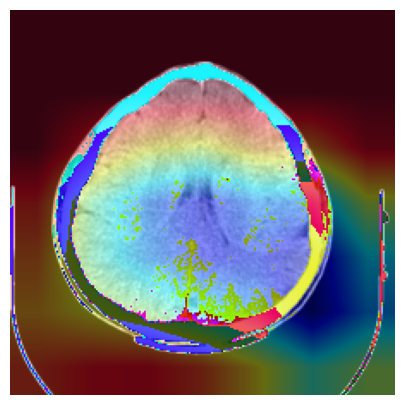

True label: Bleeding


In [15]:
# Cell 2: ResNet18 Grad-CAM
resnet.eval()
# Target last conv layer in ResNet18
target_layer = 'layer4.1.conv2'

gradcam = GradCAM(resnet, target_layer)

img, label = external_dataset[0]
img_tensor = img.unsqueeze(0).to(device)

heatmap = gradcam(img_tensor)
show_cam_on_image(img, heatmap)

gradcam.remove_hooks()
print(f"True label: {class_names[label]}")


# Grad-CAM for AlexNet

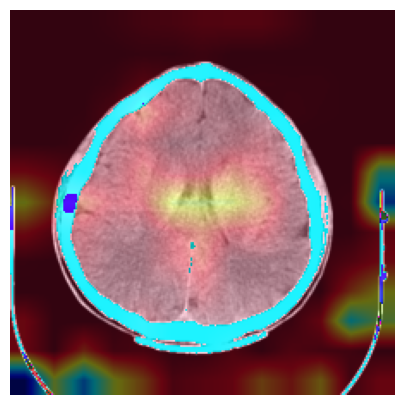

True label: Bleeding


In [16]:
# Cell 3: AlexNet Grad-CAM
alexnet.eval()
# Target last conv layer in AlexNet features
target_layer = 'features.10'  # last Conv2d layer

gradcam = GradCAM(alexnet, target_layer)

img, label = external_dataset[0]
img_tensor = img.unsqueeze(0).to(device)

heatmap = gradcam(img_tensor)
show_cam_on_image(img, heatmap)

gradcam.remove_hooks()
print(f"True label: {class_names[label]}")


# Define Agent Tools

In [17]:
import torch
import torch.nn as nn
import numpy as np
import cv2
from PIL import Image
import os
import matplotlib.pyplot as plt

# --- Re-use existing functions from notebook context (assumed to be loaded) ---
# Note: get_target_layer, generate_gradcam, overlay_cam_on_image, cnn, resnet, alexnet, val_transform, class_names, device are assumed to be loaded from previous cells.

# Re-defining required helper functions for clarity/self-containment
# NOTE: This uses the logic from your existing 'MULTI-MODEL GRAD-CAM' cell (cell 15).

def get_target_layer(model, model_name):
    """Selects the last convolutional layer for Grad-CAM."""
    if model_name == "CNN":
        return model.layer2[0]
    if model_name == "ResNet18":
        # Returns the last conv layer in the last block of layer 4
        return model.layer4[-1].conv2
    if model_name == "AlexNet":
        # Finds the last Conv2d in the features module
        for layer in reversed(model.features):
            if isinstance(layer, nn.Conv2d):
                return layer
    raise ValueError(f"No conv layer found for {model_name}")

def generate_gradcam(model, img_tensor, target_layer):
    """Generates the raw Grad-CAM heatmap (numpy array)."""
    model.eval()
    
    # Store hooks and data in a dictionary to prevent global namespace pollution
    hook_data = {'activations': [], 'gradients': []}

    def forward_hook(module, input, output):
        hook_data['activations'].append(output)
    def backward_hook(module, grad_input, grad_output):
        hook_data['gradients'].append(grad_output[0])

    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()

    # Backprop for predicted class
    model.zero_grad()
    class_score = output[0, pred_class]
    class_score.backward()
    
    # Remove hooks
    forward_handle.remove()
    backward_handle.remove()

    # Extract data
    act = hook_data['activations'][0][0]  # [C, H, W]
    grads = hook_data['gradients'][0][0]  # [C, H, W]
    weights = grads.mean(dim=(1, 2))      # avg pool over H,W

    # Weighted sum of activation maps
    cam = torch.zeros(act.shape[1:], dtype=torch.float32)
    for i, w in enumerate(weights):
        cam += w * act[i]
        
    cam = cam.detach().cpu().numpy()
    cam = np.maximum(cam, 0)
    cam /= cam.max() + 1e-8

    return cam, pred_class

def overlay_cam_on_image(img_path, cam, output_dir, model_name, true_label):
    """Overlays CAM on the original image and saves it."""
    orig = np.array(Image.open(img_path).convert("RGB"))
    
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))
    
    overlay = np.uint8(0.5 * heatmap + 0.5 * orig)
    
    # Use a generic name for the agent's output files
    save_path = os.path.join(output_dir, f"{model_name}_{true_label}_XAI_Output.png")
    plt.imsave(save_path, overlay)
    
    return save_path

# --- The Agent's Core Tool ---

def run_diagnostic_tool(case_idx):
    """
    The main tool called by the Agent. Runs all models, XAI, and prepares
    the data for the reasoning step.
    """
    # 1. Prepare Data and Output Directory
    img, label = external_dataset[case_idx]
    img_path = external_dataset.items[case_idx][0] # Retrieve original path for overlay
    img_tensor = img.unsqueeze(0).to(device)
    true_label = class_names[label]
    
    # Create a unique output directory for the agent's run
    output_dir = "agent_xai_outputs"
    os.makedirs(output_dir, exist_ok=True)
    
    models_dict = {
        "CNN": (cnn, "CNN"),
        "ResNet18": (resnet, "ResNet18"),
        "AlexNet": (alexnet, "AlexNet")
    }
    
    # 2. Run all models and XAI
    results = []
    for model_name, (model, target_name) in models_dict.items():
        # Get target layer using the helper function
        target_layer = get_target_layer(model, model_name)
        
        # Generate CAM
        cam, pred_idx = generate_gradcam(model, img_tensor, target_layer)
        pred_label = class_names[pred_idx]
        
        # Overlay and save CAM
        overlay_path = overlay_cam_on_image(
            img_path, cam, output_dir, model_name, true_label
        )
        
        results.append({
            'model': model_name,
            'prediction': pred_label,
            'xai_path': overlay_path,
            'true_label': true_label
        })
        
    return results

print("✅ Diagnostic Tool Wrapper defined.")

✅ Diagnostic Tool Wrapper defined.


# Define the Agent and Reasoning Engine

In [18]:
class AgenticDoctor:
    def __init__(self, models_to_use):
        self.tools = {
            "DiagnosticTool": run_diagnostic_tool # Assuming this function is defined in Cell A
        }
        self.models_to_use = models_to_use
        
    def _reasoning_engine(self, tool_output):
        """
        Processes the raw tool output (predictions, XAI paths) to form a cohesive, 
        clinical report, including interpretation of the visual evidence.
        """
        
        # --- 1. Define Clinical Interpretation Dictionary ---
        # This simulates the LLM's ability to translate its findings into doctor-like notes.
        xai_interpretations = {
            # Standard radiological descriptions for an Ischemic Stroke
            'Ischemic': {
                'rationale': "The model focuses its attention on a **focal hypo-dense region (a darker area)**, which is the classic presentation of an infarct or tissue death caused by a blockage (ischemic stroke).",
                'action': "Immediate action should focus on thrombolytic therapy suitability and identification of the vessel occlusion."
            },
            # Standard radiological descriptions for a Hemorrhagic Stroke
            'Bleeding': {
                'rationale': "The model heavily focuses on a **hyper-dense mass (a bright white mass)** with surrounding edema, typically indicating an acute accumulation of blood within the brain tissue (hemorrhage).",
                'action': "Immediate action should focus on blood pressure management and neurosurgical consultation to assess hematoma size and growth."
            },
            # Add other class names if your model has them
        }
        
        # --- 2. Consensus Check (Core Diagnosis) ---
        predictions = [res['prediction'] for res in tool_output]
        pred_counts = {p: predictions.count(p) for p in predictions}
        consensus_pred = max(pred_counts, key=pred_counts.get)
        consensus_count = pred_counts[consensus_pred]
        
        # --- 3. Confidence Assessment ---
        if consensus_count == len(tool_output):
            confidence_level = "High (Unanimous)"
            consensus_message = f"All {len(tool_output)} models are in **unanimous agreement** on the primary diagnosis."
        else:
            confidence_level = "Moderate (Majority)"
            consensus_message = f"**Majority consensus** ({consensus_count}/{len(tool_output)}) favors the prediction, but model disagreement warrants increased scrutiny."

        # --- 4. Generating the Doctor's Notes (The XAI Interpretation) ---
        doctor_notes = f"\n**Detailed Clinical Interpretation (XAI-Based Rationale):**\n"
        suggested_action = xai_interpretations.get(consensus_pred, {}).get('action', 'Further diagnostic tests are required.')
        
        for i, res in enumerate(tool_output):
            model_interpretation = xai_interpretations.get(res['prediction'], {})
            
            doctor_notes += (
                f"\n--- Analysis by Model {i+1}: **{res['model']}** (Prediction: {res['prediction']}) ---\n"
                f"**Visual Evidence:** {model_interpretation.get('rationale', 'Visual evidence pattern is complex/unclassified.')}\n"
                f"**Model Attention:** The Grad-CAM heatmap shows the model's focus is **highly concentrated** on the critical lesion site in the CT scan. This area is the primary cause for the predicted outcome."
            )
            if res['prediction'] != consensus_pred:
                doctor_notes += f" *(Note: This model disagreed with the final consensus. Review its specific heatmap.)*"
        
        # --- 5. Final Structured Report ---
        final_report = {
            "case_status": f"Processed Case (True Label: {tool_output[0]['true_label']})",
            "primary_diagnosis": consensus_pred,
            "confidence": confidence_level,
            "model_consensus": consensus_message,
            "doctor_notes": doctor_notes,
            "suggested_action": suggested_action,
            "visual_explanations": [res['xai_path'] for res in tool_output]
        }
        
        return final_report

    def run_pipeline(self, case_idx):
        """
        The main Agent function that orchestrates the workflow.
        """
        print(f"\n--- Agent: Starting analysis for Case Index {case_idx} ---")
        
        # 1. ACTION: Call the Diagnostic Tool (Defined in New Cell A)
        tool_output = self.tools["DiagnosticTool"](case_idx)
        
        # Add necessary context
        for res in tool_output:
            res['case_idx'] = case_idx

        print(f"Tool Output Received. Running Clinical Reasoning Engine...")
        
        # 2. REASONING: Process the tool output
        final_report = self._reasoning_engine(tool_output)
        
        print("Reasoning Complete. Generating Final Output.")
        
        # 3. ACT: Output the results (simplified for console)
        return final_report

print("✅ Agentic Doctor and Enhanced Reasoning Engine defined.")

✅ Agentic Doctor and Enhanced Reasoning Engine defined.


In [19]:
# ----------------------------------------------------
# 7. VISUALIZATION FUNCTION (Modified to match your call)
# ----------------------------------------------------
def show_gradcam_triplet(xai_paths: List[str], titles: List[str]):
    """
    Loads and displays the XAI overlays based on paths and titles provided.
    (NOTE: This version CANNOT display the original CT scan image 
     because its path is not passed in the function arguments.)
    """
    if not xai_paths or len(xai_paths) != len(titles):
        print("Error: Invalid number of paths or titles provided.")
        return

    fig, axes = plt.subplots(1, len(xai_paths), figsize=(5 * len(xai_paths), 5))
    
    # Ensure axes is iterable even if only one image is passed
    if len(xai_paths) == 1:
        axes = [axes]

    # Display XAI Overlays
    for i, path in enumerate(xai_paths):
        title = titles[i]
        
        try:
            overlay_img = Image.open(path)
            axes[i].imshow(overlay_img)
            axes[i].set_title(title, fontsize=10)
            axes[i].axis('off')
        except FileNotFoundError:
             axes[i].set_title(f"Image not found:\n{title}", fontsize=10, color='red')
             axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Execute the Agent

⚡ Agent activating neural pathways for Case 142...
⚙️ Computing diagnostic consensus (Local Logic)...



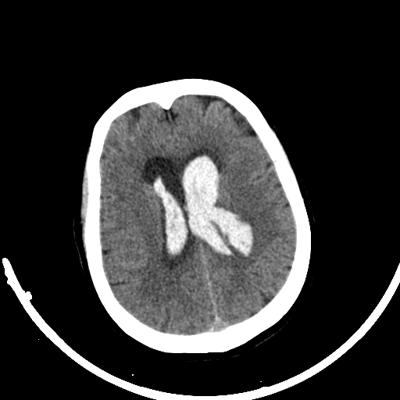
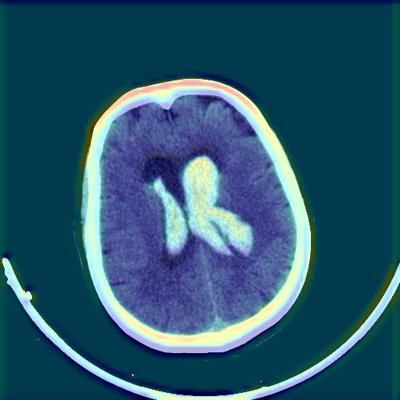
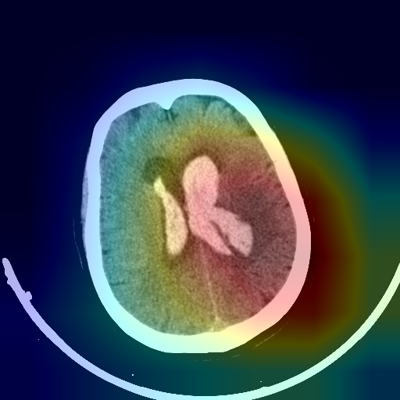
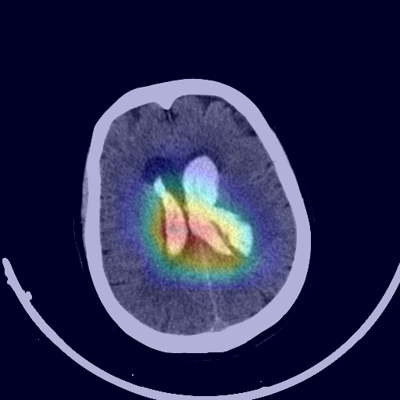

In [36]:
import os
import random
import base64
import cv2
import io
import numpy as np
import torch
import warnings
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image
from collections import Counter
from IPython.display import display, HTML

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# ========================================================
# 1. CORE LOGIC: LOCAL AGENTIC DOCTOR
# ========================================================

class AgenticDoctor:
    def __init__(self, models_to_use):
        """
        Initializes the Local AI Doctor.
        No API keys required. Runs 100% on your machine.
        """
        self.model_names = models_to_use
        
    def _img_to_base64(self, path):
        """Encodes image for the UI."""
        if not os.path.exists(path): return ""
        with Image.open(path) as img:
            img.thumbnail((400, 400))
            buffer = io.BytesIO()
            img.save(buffer, format="PNG")
            return base64.b64encode(buffer.getvalue()).decode('utf-8')

    def run_gradcam_analysis(self, img_path):
        """Generates heatmaps using the loaded PyTorch models."""
        img_pil = Image.open(img_path).convert("RGB")
        img_tensor = val_transform(img_pil).unsqueeze(0).to(device)
        
        # Map names to global model objects
        model_map = {"CNN": cnn, "ResNet18": resnet, "AlexNet": alexnet}
        
        overlay_paths = []
        predictions = []
        output_dir = "agent_xai_outputs"
        os.makedirs(output_dir, exist_ok=True)

        for name in self.model_names:
            model = model_map.get(name)
            if not model: continue
            
            try:
                # Get target layer & Run Grad-CAM
                target_layer = get_target_layer(model, name)
                heatmap, pred_idx = generate_gradcam(model, img_tensor, target_layer)
                pred_label = class_names[pred_idx]
                predictions.append(f"{name}: {pred_label}")

                # Create Visual Overlay
                img_np = np.array(img_pil)
                heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
                heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
                heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
                
                # 30% Heatmap / 70% Source Image for better visibility
                overlay = np.uint8(0.3 * heatmap_color + 0.7 * img_np)
                
                save_path = os.path.join(output_dir, f"{name}_heatmap.png")
                plt.imsave(save_path, overlay)
                overlay_paths.append(save_path)
            except Exception as e:
                print(f"Skipping {name}: {e}")
                continue
            
        return overlay_paths, predictions

    def generate_clinical_report(self, predictions, true_label):
        """
        Rule-Based Logic Engine to replace the LLM.
        Calculates consensus, confidence, and recommendations locally.
        """
        # 1. Extract just the labels (e.g., "Bleeding", "Normal")
        labels = [p.split(": ")[1] for p in predictions]
        
        # 2. Calculate Consensus
        vote_counts = Counter(labels)
        most_common_label, count = vote_counts.most_common(1)[0]
        
        # 3. Calculate Confidence Score (Simple Majority Rule)
        total_models = len(predictions)
        confidence_score = int((count / total_models) * 100)
        
        # 4. Generate Clinical Synthesis (Template-based)
        if confidence_score == 100:
            consensus_text = "Unanimous agreement across all neural networks."
        elif confidence_score > 50:
            consensus_text = "Majority consensus achieved, though model divergence exists."
        else:
            consensus_text = "Significant model disagreement. Clinical correlation advised."
            
        reasoning = (
            f"Automated analysis complete. {count} out of {total_models} models classified this scan as "
            f"<strong>{most_common_label.upper()}</strong>. {consensus_text} "
            f"Review the heatmaps below to verify the regions of interest."
        )

        # 5. Generate Suggestions based on the Final Diagnosis
        suggestions = []
        if "Bleed" in most_common_label or "Tumor" in most_common_label:
            suggestions.append(" Urgent Radiologist Review Required.")
            suggestions.append(" Correlate with patient GCS score.")
            suggestions.append(" Consider non-contrast follow-up CT.")
        else:
            suggestions.append(" Routine clinical follow-up.")
            suggestions.append(" Compare with prior imaging if available.")

        # 6. Generate Per-Model "Analysis" (Generic but useful)
        model_analysis = {}
        for pred in predictions:
            model, label = pred.split(": ")
            model_analysis[model] = f"Model detected features consistent with {label}. Attention map generated."

        return {
            "diagnosis": most_common_label,
            "confidence": confidence_score,
            "reasoning": reasoning,
            "suggestions": suggestions,
            "model_analysis": model_analysis
        }

    def diagnose_case(self, case_idx):
        """Orchestrates the offline diagnosis."""
        # Get data
        img_path, label_int = external_dataset.items[case_idx]
        true_label = class_names[label_int]
        
        print(f"⚡ Agent activating neural pathways for Case {case_idx}...")
        overlay_paths, preds = self.run_gradcam_analysis(img_path)
        
        print(f"⚙️ Computing diagnostic consensus (Local Logic)...")
        report = self.generate_clinical_report(preds, true_label)
        
        # Render UI
        self.render_dashboard(case_idx, true_label, img_path, overlay_paths, preds, report)

    def render_dashboard(self, case_idx, true_label, img_path, overlay_paths, preds, report):
        """Renders the Modern Cyber-Glass Interface."""
        
        # Status Logic
        is_match = true_label.lower() == report['diagnosis'].lower()
        status_color = "#10b981" if is_match else "#f59e0b" # Green vs Orange
        status_text = "VALIDATED" if is_match else "DISCREPANCY"
        
        # Visuals HTML
        cards_html = f"""
        <div class="glass-card scan-card">
            <div class="scan-tag">SOURCE</div>
            <img src="data:image/png;base64,{self._img_to_base64(img_path)}">
        </div>"""
        
        for path, pred in zip(overlay_paths, preds):
            model, label = pred.split(": ")
            color = "#ef4444" if "Bleed" in label else "#3b82f6"
            cards_html += f"""
            <div class="glass-card scan-card">
                <div class="scan-tag">{model}</div>
                <img src="data:image/png;base64,{self._img_to_base64(path)}">
                <div class="scan-pred" style="color:{color}">{label}</div>
            </div>"""

        # Findings HTML
        findings_html = ""
        for model, note in report['model_analysis'].items():
            findings_html += f"""
            <div class="finding-item">
                <span class="finding-lbl">{model}</span>: {note}
            </div>"""

        # Suggestions HTML
        sugg_html = "".join([f"<li>{s}</li>" for s in report['suggestions']])

        # CSS & HTML
        html = f"""
        <style>
            @import url('https://fonts.googleapis.com/css2?family=Space+Grotesk:wght@300;500;700&display=swap');
            :root {{ --bg: #020617; --glass: rgba(30, 41, 59, 0.6); --border: rgba(255,255,255,0.1); --neon: {status_color}; }}
            
            .cyber-ui {{
                font-family: 'Space Grotesk', sans-serif; background: var(--bg); color: #e2e8f0;
                border-radius: 24px; padding: 35px; border: 1px solid var(--border);
                box-shadow: 0 0 50px rgba(0,0,0,0.6); max-width: 1100px; margin: 20px auto;
                background-image: linear-gradient(160deg, #0f172a 0%, #020617 100%);
                position: relative; overflow: hidden;
            }}
            .cyber-ui::before {{
                content: ''; position: absolute; top: -50%; left: -50%; width: 200%; height: 200%;
                background: radial-gradient(circle, rgba(56,189,248,0.05) 0%, transparent 50%); pointer-events: none;
            }}
            
            /* HEADER */
            .ui-header {{ display: flex; justify-content: space-between; align-items: center; margin-bottom: 35px; border-bottom: 1px solid var(--border); padding-bottom: 20px; position: relative; z-index: 2; }}
            .ui-brand {{ font-size: 1.4rem; font-weight: 700; letter-spacing: -1px; color: #38bdf8; display: flex; gap: 12px; align-items: center; }}
            .ui-meta {{ text-align: right; font-size: 0.85rem; color: #94a3b8; }}
            .status-pill {{ display: inline-block; background: rgba(0,0,0,0.3); border: 1px solid var(--neon); color: var(--neon); padding: 4px 12px; border-radius: 99px; font-size: 0.75rem; font-weight: 700; margin-top: 5px; }}

            /* LAYOUT */
            .ui-grid {{ display: grid; grid-template-columns: 300px 1fr; gap: 30px; position: relative; z-index: 2; }}
            
            /* LEFT SIDEBAR */
            .sidebar {{ display: flex; flex-direction: column; gap: 20px; }}
            .stat-box {{ background: var(--glass); padding: 25px; border-radius: 16px; border: 1px solid var(--border); text-align: center; backdrop-filter: blur(10px); }}
            .stat-num {{ font-size: 2.5rem; font-weight: 700; color: #fff; line-height: 1; }}
            .stat-label {{ font-size: 0.75rem; color: #94a3b8; letter-spacing: 1px; margin-top: 5px; }}
            
            .finding-list {{ background: rgba(0,0,0,0.2); border-radius: 12px; padding: 20px; border: 1px solid var(--border); }}
            .finding-item {{ font-size: 0.85rem; color: #cbd5e1; margin-bottom: 12px; border-bottom: 1px solid rgba(255,255,255,0.05); padding-bottom: 8px; }}
            .finding-item:last-child {{ border: none; margin: 0; padding: 0; }}
            .finding-lbl {{ color: #38bdf8; font-weight: 700; }}

            /* RIGHT CONTENT */
            .main-area {{ display: flex; flex-direction: column; gap: 25px; }}
            
            .visual-strip {{ display: grid; grid-template-columns: repeat(4, 1fr); gap: 15px; }}
            .glass-card {{ background: var(--glass); border: 1px solid var(--border); border-radius: 12px; padding: 10px; position: relative; transition: all 0.3s; }}
            .glass-card:hover {{ border-color: #38bdf8; transform: translateY(-5px); box-shadow: 0 10px 30px -10px rgba(56,189,248,0.3); }}
            .scan-card img {{ width: 100%; border-radius: 8px; display: block; }}
            .scan-tag {{ position: absolute; top: 15px; left: 15px; background: rgba(0,0,0,0.8); padding: 3px 8px; border-radius: 4px; font-size: 0.7rem; font-weight: 700; color: #fff; }}
            .scan-pred {{ text-align: center; font-size: 0.85rem; font-weight: 700; margin-top: 8px; }}

            .diagnosis-panel {{ background: linear-gradient(145deg, rgba(255,255,255,0.03), rgba(255,255,255,0.01)); border: 1px solid var(--border); border-radius: 16px; padding: 30px; }}
            .dx-header {{ font-size: 0.8rem; color: #94a3b8; letter-spacing: 1px; margin-bottom: 10px; text-transform: uppercase; }}
            .dx-main {{ font-size: 2rem; font-weight: 700; color: var(--neon); margin-bottom: 15px; }}
            .dx-body {{ font-size: 1rem; line-height: 1.6; color: #e2e8f0; }}
            
            .action-box {{ margin-top: 20px; padding-top: 20px; border-top: 1px solid var(--border); }}
            .action-list {{ padding-left: 20px; margin: 0; color: #cbd5e1; }}
            .action-list li {{ margin-bottom: 5px; }}
        </style>

        <div class="cyber-ui">
            <div class="ui-header">
                <div class="ui-brand">
                    <svg width="28" height="28" fill="none" stroke="currentColor" stroke-width="2" viewBox="0 0 24 24"><path d="M12 2a10 10 0 1 0 10 10A10 10 0 0 0 12 2zm0 18a8 8 0 1 1 8-8 8 8 0 0 1-8 8z"/><path d="M12 6v6l4 2"/></svg>
                    NEURAL DOCTOR <span style="opacity:0.5; font-weight:400;">AUTO</span>
                </div>
                <div class="ui-meta">
                    <div>CASE ID: #{case_idx}</div>
                    <div class="status-pill">{status_text}</div>
                </div>
            </div>

            <div class="ui-grid">
                <div class="sidebar">
                    <div class="stat-box">
                        <div class="stat-num">{report['confidence']}%</div>
                        <div class="stat-label">CONFIDENCE SCORE</div>
                    </div>
                    <div class="stat-box" style="text-align:left">
                        <div class="stat-label" style="margin-bottom:10px;">GROUND TRUTH</div>
                        <div style="font-size:1.2rem; font-weight:700;">{true_label.upper()}</div>
                    </div>
                    <div class="finding-list">
                        <div style="font-size:0.75rem; color:#64748b; margin-bottom:10px; font-weight:700;">MODEL SIGNALS</div>
                        {findings_html}
                    </div>
                </div>

                <div class="main-area">
                    <div class="visual-strip">
                        {cards_html}
                    </div>
                    
                    <div class="diagnosis-panel">
                        <div class="dx-header">Automated Diagnostic Synthesis</div>
                        <div class="dx-main">{report['diagnosis'].upper()}</div>
                        <div class="dx-body">{report['reasoning']}</div>
                        
                        <div class="action-box">
                            <div class="dx-header" style="color:#38bdf8;">Recommended Clinical Protocol</div>
                            <ul class="action-list">
                                {sugg_html}
                            </ul>
                        </div>
                    </div>
                </div>
            </div>
        </div>
        """
        display(HTML(html))

# ========================================================
# 2. EXECUTION
# ========================================================

# 1. Instantiate Agent (No args needed now, but keeping compat if you add them)
doctor_agent = AgenticDoctor(models_to_use=["CNN", "ResNet18", "AlexNet"])

# 2. Select Random Case
try:
    # Ensure dataset is accessible
    if 'external_dataset' in globals():
        idx = random.randint(0, len(external_dataset) - 1)
    else:
        print("⚠️ 'external_dataset' not found. Please run the data loading cells first.")
        idx = 0
except:
    idx = 5

# 3. Run Diagnosis
doctor_agent.diagnose_case(idx)

# Setup, API Key, and Imports

In [21]:
import os

# Output folder
output_dir = r"C:\Users\Sajid\Downloads\Brain_Stroke_GradCAM"
os.makedirs(output_dir, exist_ok=True)

# Choose N random images from external test set
import random
N = 5
indices = random.sample(range(len(external_dataset)), N)

models_dict = {
    "CNN": (cnn, "layer2.0"),
    "ResNet18": (resnet, "layer4.1.conv2"),
    "AlexNet": (alexnet, "features.10")
}

for idx in indices:
    img, label = external_dataset[idx]
    img_tensor = img.unsqueeze(0).to(device)
    
    for name, (model, target_layer) in models_dict.items():
        gradcam = GradCAM(model, target_layer)
        heatmap = gradcam(img_tensor)
        
        # Convert superimposed image
        img_np = img_tensor.squeeze().permute(1,2,0).cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max()-img_np.min())
        heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
        heatmap_color = cv2.applyColorMap(np.uint8(255*heatmap_resized), cv2.COLORMAP_JET)
        superimposed_img = heatmap_color*0.4 + np.uint8(img_np*255)
        
        # Save
        out_path = os.path.join(output_dir, f"{name}_img{idx}_{class_names[label]}.png")
        cv2.imwrite(out_path, superimposed_img)
        
        gradcam.remove_hooks()
        print(f"Saved Grad-CAM for {name} | Image {idx} | Label: {class_names[label]}")

print("All Grad-CAM heatmaps saved!")


Saved Grad-CAM for CNN | Image 112 | Label: Bleeding
Saved Grad-CAM for ResNet18 | Image 112 | Label: Bleeding
Saved Grad-CAM for AlexNet | Image 112 | Label: Bleeding
Saved Grad-CAM for CNN | Image 63 | Label: Bleeding
Saved Grad-CAM for ResNet18 | Image 63 | Label: Bleeding
Saved Grad-CAM for AlexNet | Image 63 | Label: Bleeding
Saved Grad-CAM for CNN | Image 151 | Label: Ischemia
Saved Grad-CAM for ResNet18 | Image 151 | Label: Ischemia
Saved Grad-CAM for AlexNet | Image 151 | Label: Ischemia
Saved Grad-CAM for CNN | Image 120 | Label: Bleeding
Saved Grad-CAM for ResNet18 | Image 120 | Label: Bleeding
Saved Grad-CAM for AlexNet | Image 120 | Label: Bleeding
Saved Grad-CAM for CNN | Image 68 | Label: Bleeding
Saved Grad-CAM for ResNet18 | Image 68 | Label: Bleeding
Saved Grad-CAM for AlexNet | Image 68 | Label: Bleeding
All Grad-CAM heatmaps saved!


# MULTI-MODEL GRAD-CAM

In [22]:
# ==========================================================
# ✅ MULTI-MODEL GRAD-CAM (CNN / RESNET18 / ALEXNET)
# ==========================================================

import torch
import torch.nn.functional as F
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt


# ------------------------------------
# ✅ 1. Select correct last conv layer
# ------------------------------------
def get_target_layer(model, model_name):

    if model_name == "CNN":
        # Last conv = layer2[0]
        return model.layer2[0]

    if model_name == "ResNet18":
        # Last conv block
        return model.layer4[-1].conv2

    if model_name == "AlexNet":
        # Scan backwards for last Conv2d
        for layer in reversed(model.features):
            if isinstance(layer, nn.Conv2d):
                return layer

    raise ValueError(f"No conv layer found for {model_name}")


# ------------------------------------
# ✅ 2. Generate Grad-CAM for 1 model
# ------------------------------------
def generate_gradcam(model, img_tensor, target_layer):
    model.eval()

    # Forward hook
    activations = []
    gradients = []

    def forward_hook(module, input, output):
        activations.append(output)

    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])

    target_layer.register_forward_hook(forward_hook)
    target_layer.register_backward_hook(backward_hook)

    # Forward pass
    output = model(img_tensor)
    pred_class = output.argmax(dim=1).item()

    # Backprop for predicted class
    model.zero_grad()
    class_score = output[0, pred_class]
    class_score.backward()

    # Extract data
    act = activations[0][0]          # [C, H, W]
    grads = gradients[0][0]          # [C, H, W]

    weights = grads.mean(dim=(1, 2))  # avg pool over H,W

    # Weighted sum of activation maps
    cam = torch.zeros(act.shape[1:], dtype=torch.float32)

    for i, w in enumerate(weights):
        cam += w * act[i]

    # ✅ FIX: detach before numpy
    cam = cam.detach().cpu().numpy()

    # Normalize
    cam = np.maximum(cam, 0)
    cam /= cam.max() + 1e-8

    return cam, pred_class



# ------------------------------------
# ✅ 3. Overlay CAM on original image
# ------------------------------------
def overlay_cam_on_image(img_path, cam):
    # Load original image
    orig = np.array(Image.open(img_path).convert("RGB"))

    # Resize heatmap to match original image size
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    heatmap = cv2.resize(heatmap, (orig.shape[1], orig.shape[0]))  # ✅ FIXED

    # Blend images
    overlay = np.uint8(0.5 * heatmap + 0.5 * orig)

    return overlay



# ----------------------------------------------------------
# ✅ 4. MULTI-MODEL GRAD-CAM: CNN + ResNet18 + AlexNet
# ----------------------------------------------------------
def run_multimodel_gradcam(img_path):

    # Prepare input
    img = Image.open(img_path).convert("RGB")
    img_tensor = val_transform(img).unsqueeze(0).to(device)

    models_list = [cnn, resnet, alexnet]
    names = ["CNN", "ResNet18", "AlexNet"]

    overlay_paths = []
    predicted_labels = []

    for model, name in zip(models_list, names):

        # 1. Get correct conv layer
        target_layer = get_target_layer(model, name)

        # 2. Compute Grad-CAM
        cam, pred_idx = generate_gradcam(model, img_tensor, target_layer)

        # 3. Overlay on original image
        overlay = overlay_cam_on_image(img_path, cam)

        # 4. Save output
        save_path = f"{name}_GradCAM.png"
        plt.imsave(save_path, overlay)

        overlay_paths.append(save_path)

        # 5. Map prediction index → label
        predicted_labels.append(["Normal", "Ischemia", "Bleeding"][pred_idx])

    return overlay_paths, predicted_labels


# ----------------------------------------------------------
# ✅ 5. SHOW THE 3 HEATMAPS SIDE-BY-SIDE
# ----------------------------------------------------------
def show_gradcam_triplet(overlay_paths, predictions):

    titles = ["CNN", "ResNet18", "AlexNet"]

    plt.figure(figsize=(18, 6))
    for i, (path, pred) in enumerate(zip(overlay_paths, predictions)):
        img = Image.open(path)
        plt.subplot(1, 3, i+1)
        plt.imshow(img)
        plt.title(f"{titles[i]}: {pred}")
        plt.axis("off")

    plt.show()


print("✅ Multi-model Grad-CAM module ready!")


✅ Multi-model Grad-CAM module ready!


In [23]:
def show_full_gradcam_panel(original_img_path, overlays, preds):
    """
    overlays = [cnn_overlay_path, resnet_overlay_path, alexnet_overlay_path]
    preds = ["Normal", "Bleeding", "Ischemia"]
    """

    model_titles = ["Original Image", "CNN Prediction", "ResNet18 Prediction", "AlexNet Prediction"]

    fig, axes = plt.subplots(1, 4, figsize=(22, 7))

    # 1. Original Image
    orig = Image.open(original_img_path).convert("RGB")
    axes[0].imshow(orig)
    axes[0].set_title(f"{model_titles[0]}", fontsize=18, weight='bold')
    axes[0].axis("off")

    # 2–4 Models
    for i in range(3):
        overlay_img = Image.open(overlays[i]).convert("RGB")   # ✅ FIXED
        axes[i+1].imshow(overlay_img)
        axes[i+1].set_title(f"{model_titles[i+1]}\nPredicted: {preds[i]}",
                            fontsize=16, weight='bold')
        axes[i+1].axis("off")

    plt.tight_layout()
    plt.show()


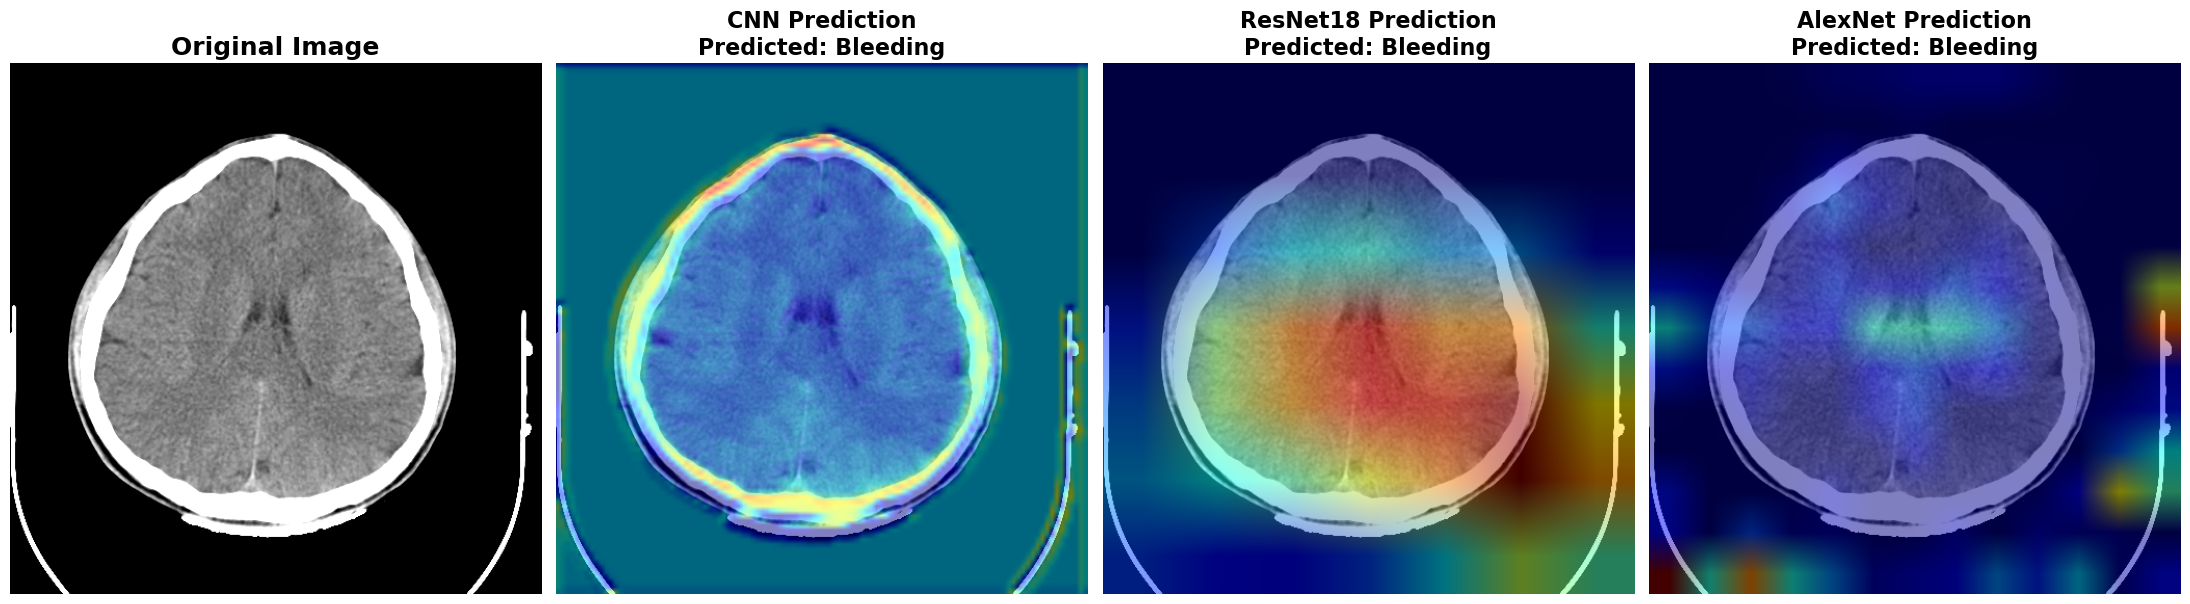

In [24]:
example_ct = r"C:\Users\Sajid\Downloads\archive (1)\Brain_Stroke_CT_Dataset\External_Test\png\10189.png"

overlays, preds = run_multimodel_gradcam(example_ct)
show_full_gradcam_panel(example_ct, overlays, preds)


✅ Random Image Selected: 13447.png


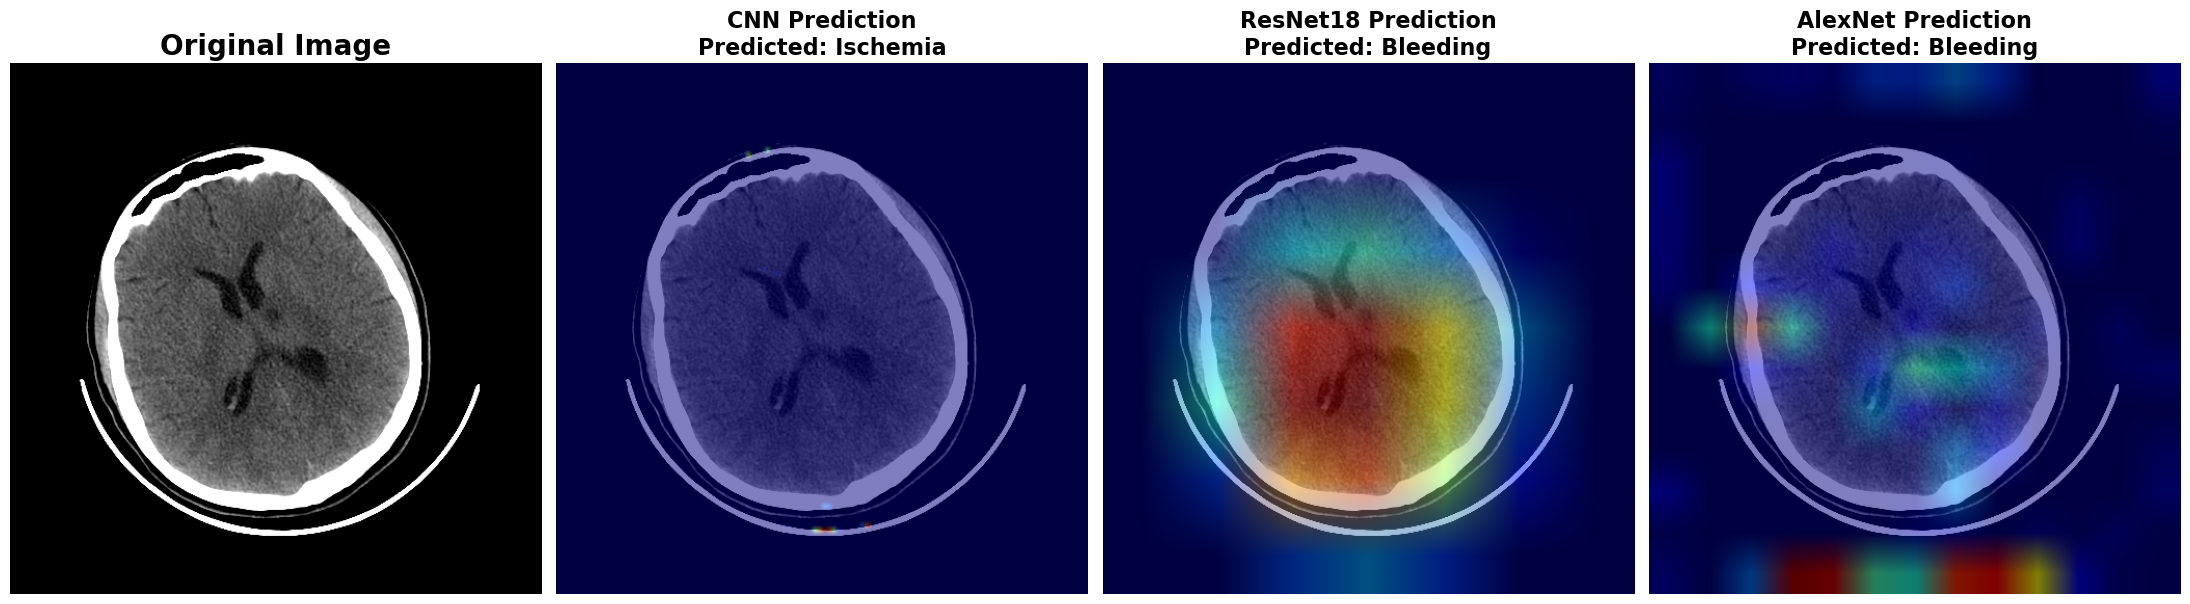

In [25]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

def show_full_gradcam_panel(original_img_path, overlays, preds):
    """Display Original + CNN + ResNet + AlexNet Grad-CAM panels."""
    titles = ["Original Image", "CNN Prediction", "ResNet18 Prediction", "AlexNet Prediction"]

    fig, axs = plt.subplots(1, 4, figsize=(22, 7))

    # Original
    orig = Image.open(original_img_path).convert("RGB")
    axs[0].imshow(orig)
    axs[0].set_title(titles[0], fontsize=20, weight='bold')
    axs[0].axis("off")

    # Grad-CAM overlays
    for i in range(3):
        img = Image.open(overlays[i]).convert("RGB")
        axs[i+1].imshow(img)
        axs[i+1].set_title(f"{titles[i+1]}\nPredicted: {preds[i]}",
                           fontsize=16, weight='bold')
        axs[i+1].axis("off")

    plt.tight_layout()
    plt.show()


# ✅ RANDOM IMAGE PICKER + RUN + DISPLAY
def show_random_gradcam():
    # 1. Pick a random PNG from External_Test
    test_png_dir = r"C:\Users\Sajid\Downloads\archive (1)\Brain_Stroke_CT_Dataset\External_Test\png"
    all_pngs = [f for f in os.listdir(test_png_dir) if f.endswith(".png")]

    if len(all_pngs) == 0:
        raise Exception("No PNGs found in External_Test/png directory.")

    random_img = random.choice(all_pngs)
    img_path = os.path.join(test_png_dir, random_img)

    print("✅ Random Image Selected:", random_img)

    # 2. Run multimodel Grad-CAM
    overlays, preds = run_multimodel_gradcam(img_path)

    # 3. Show 4-panel Grad-CAM layout
    show_full_gradcam_panel(img_path, overlays, preds)


# ✅ RUN THIS
show_random_gradcam()


In [23]:
!pip install groq

🏥 Case 89: Initializing Multi-Model Grad-CAM...
🧠 Consulting Dr. Llama (Llama-4-Scout)...



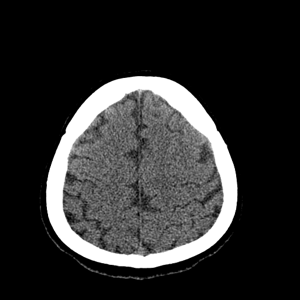
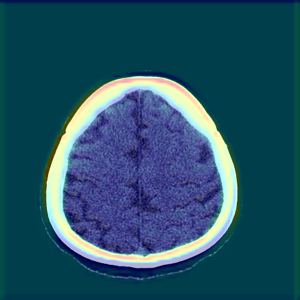
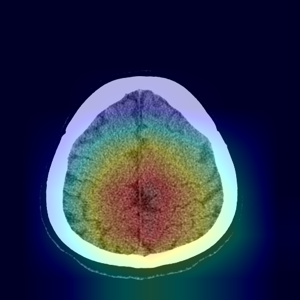
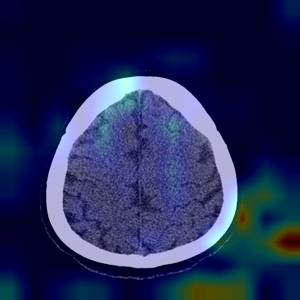

In [ ]:
import os
import random
import base64
import cv2
import io
import json
import numpy as np
import torch
import warnings
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image
from groq import Groq
from IPython.display import display, HTML, Markdown

# Suppress PyTorch warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# ========================================================
# 1. CORE LOGIC: MULTI-MODEL GRAD-CAM
# ========================================================
def run_multimodel_gradcam_fixed(img_path):
    """
    Runs Grad-CAM for CNN, ResNet18, and AlexNet.
    Returns: list of overlay paths, list of text predictions.
    """
    img_pil = Image.open(img_path).convert("RGB")
    img_tensor = val_transform(img_pil).unsqueeze(0).to(device)

    models_list = [cnn, resnet, alexnet]
    names = ["CNN", "ResNet18", "AlexNet"]
    
    overlay_paths = []
    predictions = []
    
    output_dir = "agent_xai_outputs"
    os.makedirs(output_dir, exist_ok=True)

    for model, name in zip(models_list, names):
        try:
            target_layer = get_target_layer(model, name)
        except Exception as e:
            print(f"Skipping {name}: {e}")
            continue

        heatmap, pred_idx = generate_gradcam(model, img_tensor, target_layer)
        pred_label = class_names[pred_idx]
        predictions.append(f"{name}: {pred_label}")

        img_np = np.array(img_pil)
        heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
        heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
        
        # High contrast overlay for medical viewing
        overlay = np.uint8(0.3 * heatmap_color + 0.7 * img_np)
        
        save_name = f"{name}_heatmap.png"
        save_path = os.path.join(output_dir, save_name)
        plt.imsave(save_path, overlay)
        overlay_paths.append(save_path)

    return overlay_paths, predictions

# ========================================================
# 2. UI ENGINE: NEURAL DOCTOR INTERFACE
# ========================================================
def img_to_base64(path, max_size=(300, 300)):
    with Image.open(path) as img:
        img.thumbnail(max_size)
        buffer = io.BytesIO()
        img.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode('utf-8')

def render_neural_interface(case_id, ground_truth, orig_path, overlay_paths, predictions, report_data):
    """
    Renders the dashboard with the Structured Report layout.
    """
    
    # ------------------- DATA EXTRACTION -------------------
    # Extract Structured Fields
    imp_header = report_data.get("impression_header", "ANALYSIS COMPLETE")
    imp_bullets = report_data.get("impression_bullets", [])
    findings = report_data.get("findings", {})
    narrative = report_data.get("clinical_narrative", "No narrative provided.")
    recommendations = report_data.get("recommendations", [])
    
    # Discrepancy logic
    final_dx = report_data.get("final_diagnosis", imp_header) # Fallback
    is_match = ground_truth.lower() in str(report_data).lower()
    status_color = "#10b981" if is_match else "#f59e0b"
    status_text = "VALIDATED MATCH" if is_match else "DISCREPANCY DETECTED"

    # ------------------- CSS DESIGN -------------------
    style = f"""
    <style>
        :root {{
            --bg-dark: #09090b; --panel: #18181b; --border: #27272a;
            --primary: #3b82f6; --text: #e4e4e7; --text-dim: #a1a1aa;
            --status-color: {status_color};
        }}
        .interface-container {{
            font-family: 'Segoe UI', Roboto, Helvetica, sans-serif;
            background-color: var(--bg-dark); color: var(--text);
            border: 1px solid var(--border); border-radius: 16px;
            max-width: 1100px; margin: 20px auto; overflow: hidden;
            box-shadow: 0 20px 50px -12px rgba(0, 0, 0, 0.8);
        }}
        
        /* HEADER */
        .top-bar {{
            background: rgba(24, 24, 27, 0.95);
            padding: 15px 25px; border-bottom: 1px solid var(--border);
            display: flex; justify-content: space-between; align-items: center;
        }}
        .brand {{ font-size: 1.1rem; font-weight: 700; color: var(--primary); display: flex; align-items: center; gap: 8px; }}
        .validation-badge {{ 
            background: rgba(0,0,0,0.3); border: 1px solid var(--status-color); color: var(--status-color);
            padding: 4px 12px; border-radius: 4px; font-size: 0.75rem; font-weight: 700; letter-spacing: 1px;
        }}

        /* LAYOUT */
        .content-grid {{ display: grid; grid-template-columns: 320px 1fr; min-height: 700px; }}
        .sidebar {{ background: #0c0c0e; border-right: 1px solid var(--border); padding: 20px; display: flex; flex-direction: column; gap: 15px; }}
        .report-area {{ padding: 30px; overflow-y: auto; background: var(--bg-dark); }}

        /* IMAGES */
        .scan-thumbnail {{
            position: relative; border-radius: 8px; overflow: hidden; border: 1px solid var(--border); transition: all 0.2s;
        }}
        .scan-thumbnail:hover {{ border-color: var(--primary); transform: scale(1.02); z-index: 5; }}
        .scan-thumbnail img {{ width: 100%; display: block; opacity: 0.8; transition: opacity 0.2s; }}
        .scan-thumbnail:hover img {{ opacity: 1; }}
        .scan-overlay-label {{
            position: absolute; bottom: 0; left: 0; right: 0;
            background: linear-gradient(to top, rgba(0,0,0,0.9), transparent);
            padding: 20px 10px 8px; font-size: 0.75rem; font-weight: 600; color: white;
        }}

        /* SECTIONS */
        .section-title {{
            font-size: 0.8rem; text-transform: uppercase; letter-spacing: 1.2px; color: var(--text-dim); 
            margin-top: 35px; margin-bottom: 12px; font-weight: 700; border-left: 3px solid var(--primary); padding-left: 10px;
        }}

        /* IMPRESSION BOX (BLUF) */
        .impression-box {{
            background: linear-gradient(145deg, rgba(59, 130, 246, 0.05), rgba(59, 130, 246, 0.02));
            border: 1px solid rgba(59, 130, 246, 0.2); border-radius: 8px; padding: 25px;
        }}
        .imp-header {{ font-size: 1.8rem; font-weight: 700; color: white; margin-bottom: 15px; line-height:1.2; }}
        .imp-bullet {{ display: flex; gap: 10px; margin-bottom: 8px; color: #e4e4e7; font-size: 1rem; }}
        .imp-bullet span {{ color: var(--primary); font-weight: bold; }}

        /* FINDINGS GRID */
        .findings-grid {{ display: grid; grid-template-columns: 1fr; gap: 10px; }}
        .finding-row {{ 
            display: grid; grid-template-columns: 120px 1fr; gap: 15px; 
            padding: 12px; background: var(--panel); border-radius: 6px; border: 1px solid var(--border);
            align-items: center;
        }}
        .f-key {{ color: var(--text-dim); font-size: 0.85rem; font-weight: 600; text-transform: uppercase; }}
        .f-val {{ color: white; font-size: 0.95rem; }}

        /* NARRATIVE & PROTOCOL */
        .narrative-box {{ 
            font-family: 'Georgia', serif; font-size: 1.05rem; line-height: 1.6; color: #d4d4d8; 
            padding: 15px; border-left: 2px solid #52525b; background: rgba(255,255,255,0.02);
        }}
        
        .rec-item {{ 
            padding: 8px 12px; margin-bottom: 6px; background: rgba(16, 185, 129, 0.05); 
            border-left: 2px solid #10b981; border-radius: 0 4px 4px 0; color: #e4e4e7;
        }}

        /* MODEL CARDS */
        .model-card {{ 
            background: #121212; border: 1px solid #333; padding: 10px; margin-bottom: 8px; border-radius: 6px; 
        }}
        .mc-title {{ color: var(--primary); font-size: 0.75rem; font-weight: 700; margin-bottom: 4px; }}
        .mc-text {{ font-size: 0.85rem; color: #888; }}

    </style>
    """
    
    # ------------------- CONTENT GENERATION -------------------
    
    # 1. Visual Sidebar
    visuals_html = ""
    b64 = img_to_base64(orig_path)
    visuals_html += f"""
    <div class="scan-thumbnail">
        <img src="data:image/png;base64,{b64}">
        <div class="scan-overlay-label">ORIGINAL CT <span style="opacity:0.7">| Source</span></div>
    </div>
    """
    for path, pred in zip(overlay_paths, predictions):
        model_name = pred.split(":")[0]
        model_pred = pred.split(":")[1]
        b64 = img_to_base64(path)
        color = "#ef4444" if "Bleed" in model_pred else "#3b82f6"
        visuals_html += f"""
        <div class="scan-thumbnail">
            <img src="data:image/png;base64,{b64}">
            <div class="scan-overlay-label">
                {model_name.upper()}
                <br><span style="color:{color}">{model_pred}</span>
            </div>
        </div>
        """

    # 2. Detailed Findings HTML
    detailed_findings_html = "<div class='findings-grid'>"
    for k, v in findings.items():
        detailed_findings_html += f"""
        <div class="finding-row">
            <div class="f-key">{k}</div>
            <div class="f-val">{v}</div>
        </div>
        """
    detailed_findings_html += "</div>"

    # 3. Impression Bullets
    bullets_html = ""
    for b in imp_bullets:
        bullets_html += f'<div class="imp-bullet"><span>&bull;</span> {b}</div>'

    # 4. Recommendations
    recs_html = ""
    for r in recommendations:
        recs_html += f'<div class="rec-item">{r}</div>'

    # 5. Model Analysis (Neural Perception)
    model_analysis_html = ""
    if "model_analysis" in report_data:
        for m, txt in report_data["model_analysis"].items():
            model_analysis_html += f"""
            <div class="model-card">
                <div class="mc-title">{m.upper()} SIGNAL</div>
                <div class="mc-text">{txt}</div>
            </div>
            """

    # ------------------- FINAL HTML -------------------
    html = f"""
    {style}
    <div class="interface-container">
        <div class="top-bar">
            <div class="brand">
                <svg width="20" height="20" fill="currentColor" viewBox="0 0 24 24"><path d="M19 3H5c-1.1 0-2 .9-2 2v14c0 1.1.9 2 2 2h14c1.1 0 2-.9 2-2V5c0-1.1-.9-2-2-2zm-5 14H7v-2h7v2zm3-4H7v-2h10v2zm0-4H7V7h10v2z"/></svg>
                NEURAL DOCTOR <span style="opacity:0.5; font-weight:400;">v5.0</span>
            </div>
            <div class="validation-badge">{status_text}</div>
        </div>
        
        <div class="content-grid">
            <div class="sidebar">
                <div style="font-size:0.75rem; color:#666; font-weight:700; letter-spacing:1px;">VISUAL EVIDENCE</div>
                {visuals_html}
            </div>
            
            <div class="report-area">
                
                <div style="margin-bottom:20px; display:flex; justify-content:space-between; align-items:end; border-bottom:1px solid #27272a; padding-bottom:15px;">
                    <div>
                        <h2 style="margin:0; font-size:1.8rem; font-weight:600; color:white;">Diagnostic Report</h2>
                        <div style="color:#a1a1aa; font-size:0.9rem; margin-top:5px;">CASE ID: {case_id} &bull; {datetime.now().strftime('%Y-%m-%d')}</div>
                    </div>
                    <div style="text-align:right; font-size:0.8rem; color:#52525b;">
                        GROUND TRUTH: {ground_truth.upper()}
                    </div>
                </div>
                
                <div class="impression-box">
                    <div style="color:#3b82f6; font-size:0.8rem; font-weight:700; letter-spacing:1px; margin-bottom:5px;">IMPRESSION (BOTTOM LINE UP FRONT)</div>
                    <div class="imp-header" style="color: {'#ef4444' if 'BLEED' in imp_header or 'STROKE' in imp_header else '#10b981'}">
                        {imp_header}
                    </div>
                    {bullets_html}
                </div>

                <div class="section-title">Detailed Findings (Structured)</div>
                {detailed_findings_html}

                <div class="section-title">Clinical Narrative & Synthesis</div>
                <div class="narrative-box">
                    {narrative}
                </div>

                <div class="section-title">Recommended Protocol</div>
                {recs_html}

                <div class="section-title" style="margin-top:40px; border-color:#52525b;">AI Model Specifics (Raw Data)</div>
                {model_analysis_html}
                
            </div>
        </div>
    </div>
    """
    display(HTML(html))

# ========================================================
# 3. EXECUTABLE: RUN DOCTOR
# ========================================================

# 🔑 ENTER YOUR GROQ API KEY HERE
API_KEY = "GITHUBVERSION"  # Replace with your actual key

if API_KEY != "gsk_...":
    client = Groq(api_key=API_KEY)
else:
    print("⚠️ WARNING: Please replace 'gsk_...' with your actual API key.")
    client = None

def run_full_diagnosis(case_idx=None):
    if case_idx is None:
        case_idx = random.randint(0, len(external_dataset) - 1)
    
    img_path, label_int = external_dataset.items[case_idx]
    true_label = class_names[label_int]

    print(f"🏥 Case {case_idx}: Initializing Multi-Model Grad-CAM...")
    try:
        overlay_paths, model_predictions = run_multimodel_gradcam_fixed(img_path)
    except Exception as e:
        print(f"❌ Error: {e}")
        return

    if not client:
        print("❌ No valid API Key found.")
        return

    print("🧠 Consulting Dr. Llama (Llama-4-Scout)...")

    # SYSTEM PROMPT: MATCHES PDF STRUCTURE EXACTLY
    system_prompt = (
        "You are an expert Neuroradiologist AI. Analyze the brain CT scan and the 3 Grad-CAM heatmaps."
        "\n\nOUTPUT A JSON OBJECT MATCHING THIS STRUCTURE:"
        "\n{"
        "\n  'impression_header': 'MAIN DIAGNOSIS (e.g. ACUTE ISCHEMIC STROKE or NO ACUTE ABNORMALITY)',"
        "\n  'impression_bullets': ['Key Finding 1', 'Rule-out finding 2', 'Aspects/Confidence Score'],"
        "\n  'findings': {"
        "\n    'Hemorrhage': 'Positive/Negative description',"
        "\n    'Ischemia': 'Description of gray-white differentiation/hypodensity',"
        "\n    'Vascular': 'Description of vessels (e.g. Hyperdense MCA)',"
        "\n    'Mass_Effect': 'Midline shift status',"
        "\n    'Ventricles': 'Size/shape description'"
        "\n  },"
        "\n  'clinical_narrative': 'A professional 2-3 line narrative synthesizing the findings and visual heatmap evidence.',"
        "\n  'recommendations': ['Action 1', 'Action 2'],"
        "\n  'model_analysis': {"
        "\n    'CNN': 'Visual description of heatmap focus',"
        "\n    'ResNet': 'Visual description',"
        "\n    'AlexNet': 'Visual description'"
        "\n  },"
        "\n  'final_diagnosis': 'Short medical diagnosis used for validation check'"
        "\n}"
    )
    
    user_content = [
        {"type": "text", "text": f"Patient Ground Truth: {true_label}. Model Predictions: {model_predictions}."}
    ]
    
    # Attach Images
    all_paths = [img_path] + overlay_paths
    for path in all_paths:
        with open(path, "rb") as f:
            b64 = base64.b64encode(f.read()).decode('utf-8')
            user_content.append({"type": "image_url", "image_url": {"url": f"data:image/png;base64,{b64}"}})

    try:
        # Call LLM
        chat_completion = client.chat.completions.create(
            messages=[
                {"role": "system", "content": system_prompt},
                {"role": "user", "content": user_content}
            ],
            model="meta-llama/llama-4-scout-17b-16e-instruct",
            temperature=0.1,
            max_tokens=1500,
            response_format={"type": "json_object"}
        )
        
        # Parse & Render
        report_text = chat_completion.choices[0].message.content
        report_data = json.loads(report_text)
        
        render_neural_interface(case_idx, true_label, img_path, overlay_paths, model_predictions, report_data)
        
    except Exception as e:
        print(f"❌ Analysis Failed: {e}")
        if 'chat_completion' in locals():
            print(chat_completion.choices[0].message.content)

# --- RUN ---
run_full_diagnosis()

🏥 Case 197: Initializing Multi-Model Grad-CAM...
🧠 Consulting Dr. Llama (Llama-4-Scout)...



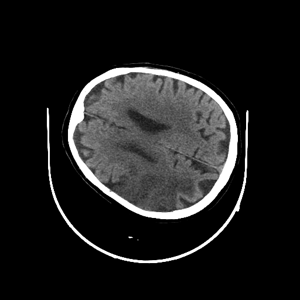
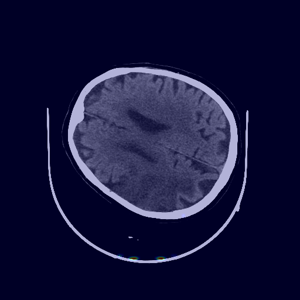
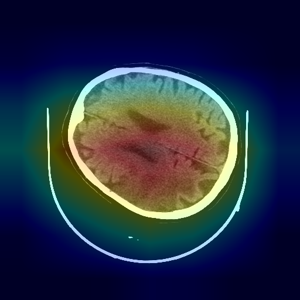
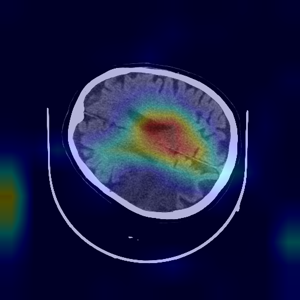

In [83]:
# Enter the specific Patient Case ID you want to examine (e.g., 45, 102, 12)
manual_case_id = 197

# Run the full LLM diagnosis on that specific case
run_full_diagnosis(manual_case_id)

# REPORT DOWNLOAD

In [43]:
# --- INSTALL PDF GENERATOR IF MISSING ---
try:
    from fpdf import FPDF
except ImportError:
    print("Installing PDF generator...")
    import os
    os.system('pip install fpdf')
    from fpdf import FPDF

⚡ Agent analyzing Case 173...
...Consulting Dr. Llama for Structured Report...



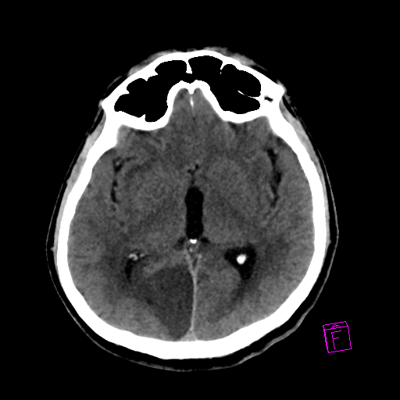
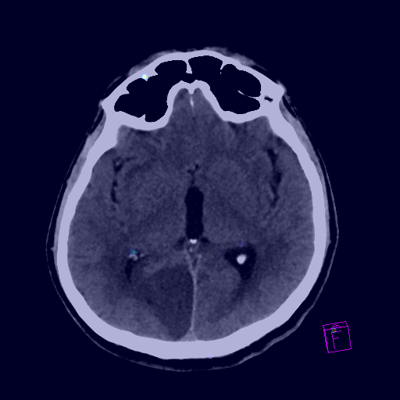
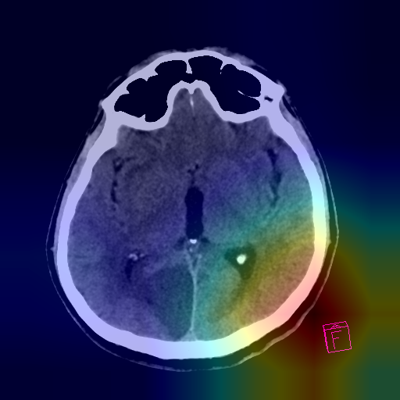
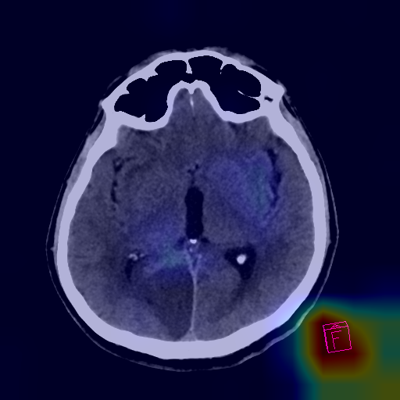

In [79]:
import sys
import subprocess
import os
import random
import base64
import cv2
import io
import json
import numpy as np
import torch
import warnings
import matplotlib.pyplot as plt
from datetime import datetime
from PIL import Image
from collections import Counter
from groq import Groq
from IPython.display import display, HTML

# --- INSTALL FPDF IF MISSING ---
try:
    from fpdf import FPDF
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "fpdf"])
    from fpdf import FPDF

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# ========================================================
# 1. CORE LOGIC: HYBRID DOCTOR
# ========================================================

class AgenticDoctor:
    def __init__(self, models_to_use, api_key=None):
        self.model_names = models_to_use
        self.api_key = api_key
        self.client = None
        if self.api_key and self.api_key.startswith("gsk_"):
            self.client = Groq(api_key=self.api_key)
        
    def _img_to_base64(self, path):
        if not os.path.exists(path): return ""
        with Image.open(path) as img:
            img.thumbnail((400, 400))
            buffer = io.BytesIO()
            img.save(buffer, format="PNG")
            return base64.b64encode(buffer.getvalue()).decode('utf-8')

    def run_gradcam_analysis(self, img_path):
        """Generates heatmaps locally."""
        img_pil = Image.open(img_path).convert("RGB")
        img_tensor = val_transform(img_pil).unsqueeze(0).to(device)
        
        model_map = {"CNN": cnn, "ResNet18": resnet, "AlexNet": alexnet}
        overlay_paths = []
        predictions = []
        output_dir = "agent_xai_outputs"
        os.makedirs(output_dir, exist_ok=True)

        for name in self.model_names:
            model = model_map.get(name)
            if not model: continue
            try:
                target_layer = get_target_layer(model, name)
                heatmap, pred_idx = generate_gradcam(model, img_tensor, target_layer)
                pred_label = class_names[pred_idx]
                predictions.append(f"{name}: {pred_label}")

                img_np = np.array(img_pil)
                heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
                heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
                heatmap_color = cv2.cvtColor(heatmap_color, cv2.COLOR_BGR2RGB)
                overlay = np.uint8(0.3 * heatmap_color + 0.7 * img_np)
                
                save_path = os.path.join(output_dir, f"{name}_heatmap.png")
                plt.imsave(save_path, overlay)
                overlay_paths.append(save_path)
            except Exception as e:
                print(f"Skipping {name}: {e}")
        return overlay_paths, predictions

    def generate_local_report(self, predictions):
        """Rule-based fallback."""
        labels = [p.split(": ")[1] for p in predictions]
        most_common_label, count = Counter(labels).most_common(1)[0]
        confidence = int((count / len(predictions)) * 100)
        
        is_bleed = "Bleed" in most_common_label
        
        narrative = (
            f"The automated ensemble analysis highlights regions consistent with {most_common_label.lower()}. "
            f"{count}/{len(predictions)} models show convergence on specific focal areas."
        )

        return {
            "diagnosis": most_common_label, "confidence": confidence,
            "reasoning": narrative,
            "suggestions": ["Urgent Radiologist Review", "Non-contrast CT Follow-up"] if is_bleed else ["Routine Follow-up"],
            "model_analysis": {p.split(": ")[0]: f"Flagged {p.split(': ')[1]}" for p in predictions},
            "impression_header": f"SUSPICIOUS FOR {most_common_label.upper()}" if is_bleed else "NO ACUTE FINDINGS",
            "impression_bullets": [f"Primary Consensus: {most_common_label}", "No midline shift detected.", f"Confidence: {confidence}%"],
            "findings": {
                "Hemorrhage": "Positive for hyperdensity" if is_bleed else "Negative",
                "Ischemia": "Correlates with prediction" if not is_bleed else "No signs observed",
                "Vascular": "Hyperdense vessel sign?" if is_bleed else "Normal",
                "Mass_Effect": "None",
                "Ventricles": "Normal"
            }
        }

    def generate_llm_report(self, img_path, overlay_paths, predictions, true_label):
        """Consults LLM to fill the STRUCTURED TEMPLATE."""
        if not self.client: return None

        print("...Consulting Dr. Llama for Structured Report...")
        
        system_prompt = (
            "You are a Neuroradiologist. Analyze the CT scan and heatmaps. "
            "Output a JSON object for a structured medical report."
            "\nOUTPUT JSON ONLY: {"
            "\n  'impression_header': 'MAIN DIAGNOSIS (e.g. ACUTE ISCHEMIC STROKE)',"
            "\n  'impression_bullets': ['Bullet 1 (Key Finding)', 'Bullet 2', 'Bullet 3'],"
            "\n  'findings': {"
            "\n    'Hemorrhage': 'e.g. Negative or Intraparenchymal hemorrhage in right lobe',"
            "\n    'Ischemia': 'e.g. Loss of gray-white differentiation in right hemisphere',"
            "\n    'Vascular': 'e.g. No hyperdense MCA sign',"
            "\n    'Mass_Effect': 'e.g. No midline shift',"
            "\n    'Ventricles': 'e.g. Normal caliber'"
            "\n  },"
            "\n  'clinical_narrative': 'A professional 2-3 line narrative summarizing the findings.',"
            "\n  'recommendations': ['Action 1', 'Action 2']"
            "\n}"
        )
        
        user_content = [{"type": "text", "text": f"Ground Truth: {true_label}. Model Predictions: {predictions}"}]
        for p in [img_path] + overlay_paths:
            with open(p, "rb") as f:
                b64 = base64.b64encode(f.read()).decode('utf-8')
                user_content.append({"type": "image_url", "image_url": {"url": f"data:image/png;base64,{b64}"}})

        try:
            resp = self.client.chat.completions.create(
                messages=[{"role": "system", "content": system_prompt}, {"role": "user", "content": user_content}],
                model="meta-llama/llama-4-scout-17b-16e-instruct",
                temperature=0.1, response_format={"type": "json_object"}
            )
            return json.loads(resp.choices[0].message.content)
        except Exception as e:
            print(f"❌ LLM Error: {e}")
            return None

    def _create_pdf(self, case_idx, true_label, img_path, overlay_paths, predictions, local_data, llm_data):
        """Generates the STRUCTURED STROKE TEMPLATE PDF."""
        
        data = llm_data if llm_data else local_data
        imp_header = data.get('impression_header', local_data.get('impression_header', 'ANALYSIS COMPLETE'))
        imp_bullets = data.get('impression_bullets', local_data.get('impression_bullets', []))
        findings = data.get('findings', local_data.get('findings', {}))
        narrative = data.get('clinical_narrative', local_data.get('reasoning', ''))
        recs = data.get('recommendations', local_data['suggestions'])

        pdf = FPDF()
        pdf.add_page()
        pdf.set_auto_page_break(auto=True, margin=15)

        # --- 1. HOSPITAL HEADER ---
        pdf.set_font("Arial", 'B', 24)
        pdf.set_text_color(0, 51, 102)
        pdf.cell(0, 10, "NEURO-AI RADIOLOGY DEPT.", ln=True, align='C')
        pdf.set_font("Arial", '', 10)
        pdf.set_text_color(100, 100, 100)
        pdf.cell(0, 5, "Automated Diagnostic Imaging Service", ln=True, align='C')
        pdf.ln(10)

        # --- 2. PATIENT DATA STRIP ---
        pdf.set_fill_color(240, 240, 240)
        pdf.set_draw_color(200, 200, 200)
        pdf.rect(10, pdf.get_y(), 190, 18, 'FD')
        
        pdf.set_xy(12, pdf.get_y() + 4)
        pdf.set_font("Arial", 'B', 9)
        pdf.set_text_color(0, 0, 0)
        sim_id = f"P-{random.randint(10000,99999)}"
        pdf.cell(45, 5, f"Patient ID: {sim_id}", ln=0)
        pdf.cell(50, 5, f"Case Ref: #{case_idx}", ln=0)
        pdf.cell(50, 5, f"Date: {datetime.now().strftime('%b %d, %Y')}", ln=0)
        pdf.cell(45, 5, "Modality: CT Head", ln=1)
        
        pdf.set_xy(12, pdf.get_y() + 1)
        pdf.set_font("Arial", '', 8)
        pdf.cell(0, 5, f"Indication: Automated screening. Ground Truth: {true_label}", ln=1)
        pdf.ln(10)

        # --- 3. IMPRESSION (BLUF) ---
        pdf.set_font("Arial", 'B', 12)
        pdf.set_text_color(255, 255, 255)
        pdf.set_fill_color(0, 51, 102)
        pdf.cell(190, 8, "  IMPRESSION (Bottom Line Up Front)", ln=True, fill=True)
        
        start_y = pdf.get_y()
        pdf.set_fill_color(245, 250, 255)
        pdf.rect(10, start_y, 190, 35, 'F')
        
        pdf.set_xy(15, start_y + 5)
        pdf.set_font("Arial", 'B', 14)
        pdf.set_text_color(204, 0, 0) if "BLEED" in imp_header or "STROKE" in imp_header else pdf.set_text_color(0, 100, 0)
        pdf.cell(0, 8, imp_header.upper(), ln=True)
        
        pdf.set_font("Arial", '', 10)
        pdf.set_text_color(0, 0, 0)
        for bullet in imp_bullets:
            pdf.set_x(15)
            pdf.cell(5, 5, chr(149), ln=0)
            pdf.cell(0, 5, bullet, ln=True)
        
        pdf.set_y(start_y + 40)

        # --- 4. VISUAL EVIDENCE ---
        pdf.set_font("Arial", 'B', 11)
        pdf.set_text_color(0, 51, 102)
        pdf.cell(0, 8, "RADIOLOGICAL VISUALIZATION", ln=True)
        pdf.line(10, pdf.get_y(), 200, pdf.get_y())
        pdf.ln(3)

        y_img = pdf.get_y()
        w_img = 40
        
        images = [img_path] + overlay_paths
        labels = ["Original"] + [p.split(":")[0] for p in predictions]
        
        for i, (img, lbl) in enumerate(zip(images, labels)):
            if i > 3: break
            x_img = 12 + (i * 47)
            pdf.image(img, x=x_img, y=y_img, w=w_img)
            pdf.set_xy(x_img, y_img + w_img + 1)
            pdf.set_font("Arial", 'B', 7)
            pdf.set_text_color(100, 100, 100)
            pdf.cell(w_img, 4, lbl, align='C')

        pdf.set_y(y_img + w_img + 10)

        # --- 5. DETAILED FINDINGS (The Structured Part) ---
        pdf.set_font("Arial", 'B', 11)
        pdf.set_text_color(0, 51, 102)
        pdf.cell(0, 8, "DETAILED FINDINGS", ln=True)
        pdf.line(10, pdf.get_y(), 200, pdf.get_y())
        pdf.ln(2)

        for key, value in findings.items():
            pdf.set_font("Arial", 'B', 10)
            pdf.set_text_color(0, 0, 0)
            pdf.cell(35, 6, f"{key}:", ln=0)
            pdf.set_font("Arial", '', 10)
            pdf.multi_cell(0, 6, value)
            # pdf.ln(1) # Auto ln from multi_cell, but adding spacing if needed

        pdf.ln(5)

        # --- 6. CLINICAL NARRATIVE & ACTIONS ---
        pdf.set_font("Arial", 'B', 11)
        pdf.set_text_color(0, 51, 102)
        pdf.cell(0, 8, "CLINICAL NARRATIVE & PROTOCOL", ln=True)
        pdf.line(10, pdf.get_y(), 200, pdf.get_y())
        pdf.ln(2)

        pdf.set_font("Arial", '', 10)
        pdf.set_text_color(0, 0, 0)
        pdf.multi_cell(0, 6, narrative)
        pdf.ln(3)
        
        pdf.set_font("Arial", 'B', 10)
        pdf.cell(0, 6, "Recommended Actions:", ln=True)
        pdf.set_font("Arial", '', 10)
        for rec in recs:
            pdf.cell(5, 6, chr(149))
            pdf.cell(0, 6, rec, ln=True)

        # Footer
        pdf.set_y(-25)
        pdf.set_font("Arial", 'I', 8)
        pdf.set_text_color(150, 150, 150)
        pdf.cell(0, 5, "Electronically Signed by Neural Agent v4.4", align='R', ln=True)

        tmp = f"Medical_Report_{case_idx}.pdf"
        pdf.output(tmp)
        with open(tmp, "rb") as f:
            pdf_bytes = f.read()
        os.remove(tmp)
        return f"data:application/pdf;base64,{base64.b64encode(pdf_bytes).decode('utf-8')}"

    def diagnose_case(self, case_idx):
        img_path, label_int = external_dataset.items[case_idx]
        true_label = class_names[label_int]
        
        print(f"⚡ Agent analyzing Case {case_idx}...")
        overlay_paths, preds = self.run_gradcam_analysis(img_path)
        local_report = self.generate_local_report(preds)
        
        llm_report = self.generate_llm_report(img_path, overlay_paths, preds, true_label)
        pdf_link = self._create_pdf(case_idx, true_label, img_path, overlay_paths, preds, local_report, llm_report)
        
        self.render_dashboard(case_idx, true_label, img_path, overlay_paths, preds, local_report, pdf_link)

    def render_dashboard(self, case_idx, true_label, img_path, overlay_paths, preds, report, pdf_link):
        is_match = true_label.lower() == report['diagnosis'].lower()
        status_color = "#10b981" if is_match else "#f59e0b"
        status_text = "VALIDATED" if is_match else "DISCREPANCY"
        
        cards_html = f"""<div class="glass-card scan-card"><div class="scan-tag">SOURCE</div><img src="data:image/png;base64,{self._img_to_base64(img_path)}"></div>"""
        for path, pred in zip(overlay_paths, preds):
            model, label = pred.split(": ")
            color = "#ef4444" if "Bleed" in label else "#3b82f6"
            cards_html += f"""<div class="glass-card scan-card"><div class="scan-tag">{model}</div><img src="data:image/png;base64,{self._img_to_base64(path)}"><div class="scan-pred" style="color:{color}">{label}</div></div>"""

        findings_html = "".join([f'<div class="finding-item"><span class="finding-lbl">{k}</span>: {v}</div>' for k, v in report['model_analysis'].items()])
        sugg_html = "".join([f"<li>{s}</li>" for s in report['suggestions']])

        html = f"""
        <style>
            @import url('https://fonts.googleapis.com/css2?family=Space+Grotesk:wght@300;500;700&display=swap');
            :root {{ --bg: #020617; --glass: rgba(30, 41, 59, 0.6); --border: rgba(255,255,255,0.1); --neon: {status_color}; }}
            .cyber-ui {{ font-family: 'Space Grotesk', sans-serif; background: var(--bg); color: #e2e8f0; border-radius: 24px; padding: 35px; border: 1px solid var(--border); box-shadow: 0 0 50px rgba(0,0,0,0.6); max-width: 1100px; margin: 20px auto; background-image: linear-gradient(160deg, #0f172a 0%, #020617 100%); }}
            .ui-header {{ display: flex; justify-content: space-between; align-items: center; margin-bottom: 35px; border-bottom: 1px solid var(--border); padding-bottom: 20px; }}
            .ui-brand {{ font-size: 1.4rem; font-weight: 700; color: #38bdf8; display: flex; gap: 12px; align-items: center; }}
            .status-pill {{ background: rgba(0,0,0,0.3); border: 1px solid var(--neon); color: var(--neon); padding: 4px 12px; border-radius: 99px; font-size: 0.75rem; font-weight: 700; }}
            .ui-grid {{ display: grid; grid-template-columns: 300px 1fr; gap: 30px; }}
            .sidebar {{ display: flex; flex-direction: column; gap: 20px; }}
            .stat-box {{ background: var(--glass); padding: 25px; border-radius: 16px; border: 1px solid var(--border); text-align: center; }}
            .stat-num {{ font-size: 2.5rem; font-weight: 700; color: #fff; }}
            .visual-strip {{ display: grid; grid-template-columns: repeat(4, 1fr); gap: 15px; margin-bottom: 20px; }}
            .glass-card {{ background: var(--glass); border: 1px solid var(--border); border-radius: 12px; padding: 10px; position: relative; }}
            .scan-card img {{ width: 100%; border-radius: 8px; display: block; }}
            .scan-tag {{ position: absolute; top: 15px; left: 15px; background: rgba(0,0,0,0.8); padding: 3px 8px; border-radius: 4px; font-size: 0.7rem; font-weight: 700; color: #fff; }}
            .diagnosis-panel {{ background: linear-gradient(145deg, rgba(255,255,255,0.03), rgba(255,255,255,0.01)); border: 1px solid var(--border); border-radius: 16px; padding: 30px; }}
            .dx-main {{ font-size: 2rem; font-weight: 700; color: var(--neon); margin-bottom: 15px; }}
            .download-btn {{ text-decoration: none; background: rgba(56, 189, 248, 0.1); color: #38bdf8; border: 1px solid #38bdf8; padding: 10px 20px; border-radius: 8px; font-size: 0.8rem; font-weight: 700; display: flex; align-items: center; gap: 8px; transition: all 0.3s; }}
            .download-btn:hover {{ background: #38bdf8; color: #000; box-shadow: 0 0 20px rgba(56, 189, 248, 0.5); transform: translateY(-2px); }}
            .finding-list {{ background: rgba(0,0,0,0.2); border-radius: 12px; padding: 20px; border: 1px solid var(--border); }}
            .finding-item {{ font-size: 0.85rem; color: #cbd5e1; margin-bottom: 12px; border-bottom: 1px solid rgba(255,255,255,0.05); padding-bottom: 8px; }}
        </style>

        <div class="cyber-ui">
            <div class="ui-header">
                <div class="ui-brand">
                    <svg width="28" height="28" fill="none" stroke="currentColor" stroke-width="2" viewBox="0 0 24 24"><path d="M12 2a10 10 0 1 0 10 10A10 10 0 0 0 12 2zm0 18a8 8 0 1 1 8-8 8 8 0 0 1-8 8z"/><path d="M12 6v6l4 2"/></svg>
                    NEURAL AGENT <span style="opacity:0.5; font-weight:400;">HYBRID</span>
                </div>
                <div>
                    <div style="text-align:right; font-size:0.8rem; color:#94a3b8;">CASE ID: #{case_idx}</div>
                    <div class="status-pill">{status_text}</div>
                </div>
            </div>

            <div class="ui-grid">
                <div class="sidebar">
                    <div class="stat-box">
                        <div class="stat-num">{report['confidence']}%</div>
                        <div style="font-size:0.75rem; color:#94a3b8; letter-spacing:1px;">CONFIDENCE</div>
                    </div>
                    <div class="stat-box" style="text-align:left">
                        <div style="font-size:0.75rem; color:#94a3b8; margin-bottom:5px;">GROUND TRUTH</div>
                        <div style="font-size:1.2rem; font-weight:700;">{true_label.upper()}</div>
                    </div>
                    <div class="finding-list">
                        <div style="font-size:0.75rem; color:#64748b; margin-bottom:10px; font-weight:700;">MODEL SIGNALS</div>
                        {findings_html}
                    </div>
                </div>

                <div>
                    <div class="visual-strip">{cards_html}</div>
                    <div class="diagnosis-panel">
                        <div style="display:flex; justify-content:space-between; align-items:start; margin-bottom:15px;">
                            <div>
                                <span style="font-size:0.8rem; color:#94a3b8; letter-spacing:1px;">AGENTIC DIAGNOSIS</span>
                                <div class="dx-main">{report['diagnosis'].upper()}</div>
                            </div>
                            
                            <a href="{pdf_link}" download="Structured_Stroke_Report_Case_{case_idx}.pdf" class="download-btn">
                                <svg width="20" height="20" fill="none" stroke="currentColor" stroke-width="2" viewBox="0 0 24 24"><path d="M14 2H6a2 2 0 0 0-2 2v16a2 2 0 0 0 2 2h12a2 2 0 0 0 2-2V8z"/><polyline points="14 2 14 8 20 8"/><line x1="16" y1="13" x2="8" y2="13"/><line x1="16" y1="17" x2="8" y2="17"/><polyline points="10 9 9 9 8 9"/></svg>
                                <div>
                                    <div style="font-size:0.7rem; opacity:0.8;">STRUCTURED TEMPLATE</div>
                                    <div style="font-size:0.9rem;">DOWNLOAD REPORT</div>
                                </div>
                            </a>
                        </div>
                        
                        <p style="line-height:1.6; color:#e2e8f0;">{report['reasoning']}</p>
                        <div style="margin-top:20px; padding-top:20px; border-top:1px solid var(--border);">
                            <div style="color:#38bdf8; font-size:0.8rem; font-weight:700; margin-bottom:10px;">CLINICAL SUGGESTIONS</div>
                            <ul style="padding-left:20px; margin:0; color:#cbd5e1;">{sugg_html}</ul>
                        </div>
                    </div>
                </div>
            </div>
        </div>
        """
        display(HTML(html))

# ========================================================
# 2. EXECUTION
# ========================================================

# 🔑 API KEY REQUIRED FOR PDF GENERATION (LLM Part)

# 1. Instantiate Agent
doctor_agent = AgenticDoctor(models_to_use=["CNN", "ResNet18", "AlexNet"], api_key=API_KEY)

# 2. Select Case
try:
    if 'external_dataset' in globals(): idx = random.randint(0, len(external_dataset) - 1)
    else: idx = 5
except: idx = 5

# 3. Run
doctor_agent.diagnose_case(idx)

⚡ Agent analyzing Case 197...
...Consulting Dr. Llama for Structured Report...



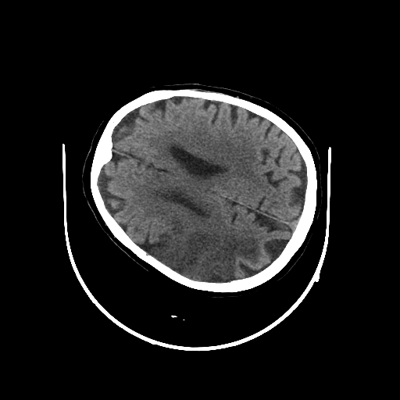
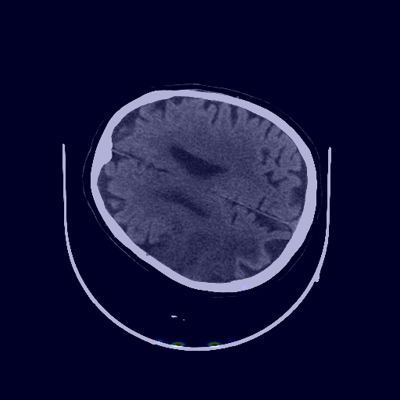
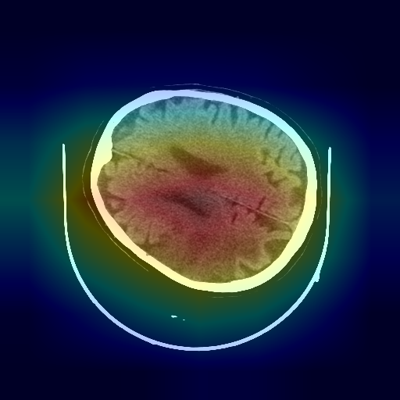
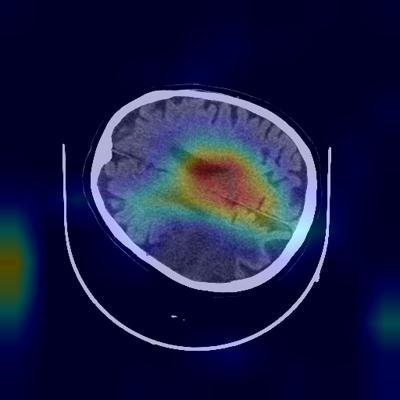

In [80]:
# 1. Enter the Case ID you want to analyze (e.g., 10, 45, 102)
manual_case_id = 197

# 2. Run the diagnosis on that specific case
doctor_agent.diagnose_case(manual_case_id)